# Import delle librerie

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import silhouette_score
import matplotlib as mpl

c:\Users\Leo\.conda\envs\bigdata\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# carichiamo i risultati del k-means più serie temporali

In [2]:
with open('./pickles/kmeans_total.pickle', 'rb') as handle:
    kmeans_total = pickle.load(handle)

with open('./pickles/newSeries_total.pickle', 'rb') as handle:
    newSeries_total = pickle.load(handle)

with open('./pickles/rese_total.pickle', 'rb') as handle:
    rese_total = pickle.load(handle)

with open('./pickles/newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

In [3]:
# Numero di cluster 

num_cluster = 5

# Rese pulite

newResa3 = newResa3[(newResa3<=11000) & (newResa3 >= 4000)]


# Andiamo a fare il plot della silhoutte

In [4]:
silhoutte = []

for x in range(0,int(155/5)):
    silhoutte.append([])
    for y in range(0,int(155/5)):
        if(newSeries_total[x,y] is not None):
            silhoutte[-1].append(silhouette_score(newSeries_total[x,y],kmeans_total[x,y],metric="euclidean"))
        else:
            continue

In [5]:
# Abbiamo una matrice triangolare incompleta, dobbiamo riempirla.

matrice_silhoutte = np.zeros([int(155/5),int(155/5)])

for a,x in zip(silhoutte,range(0,int(150/5))):
    for c,y in zip(a,range(0,len(a))):
        matrice_silhoutte[x,y] = c

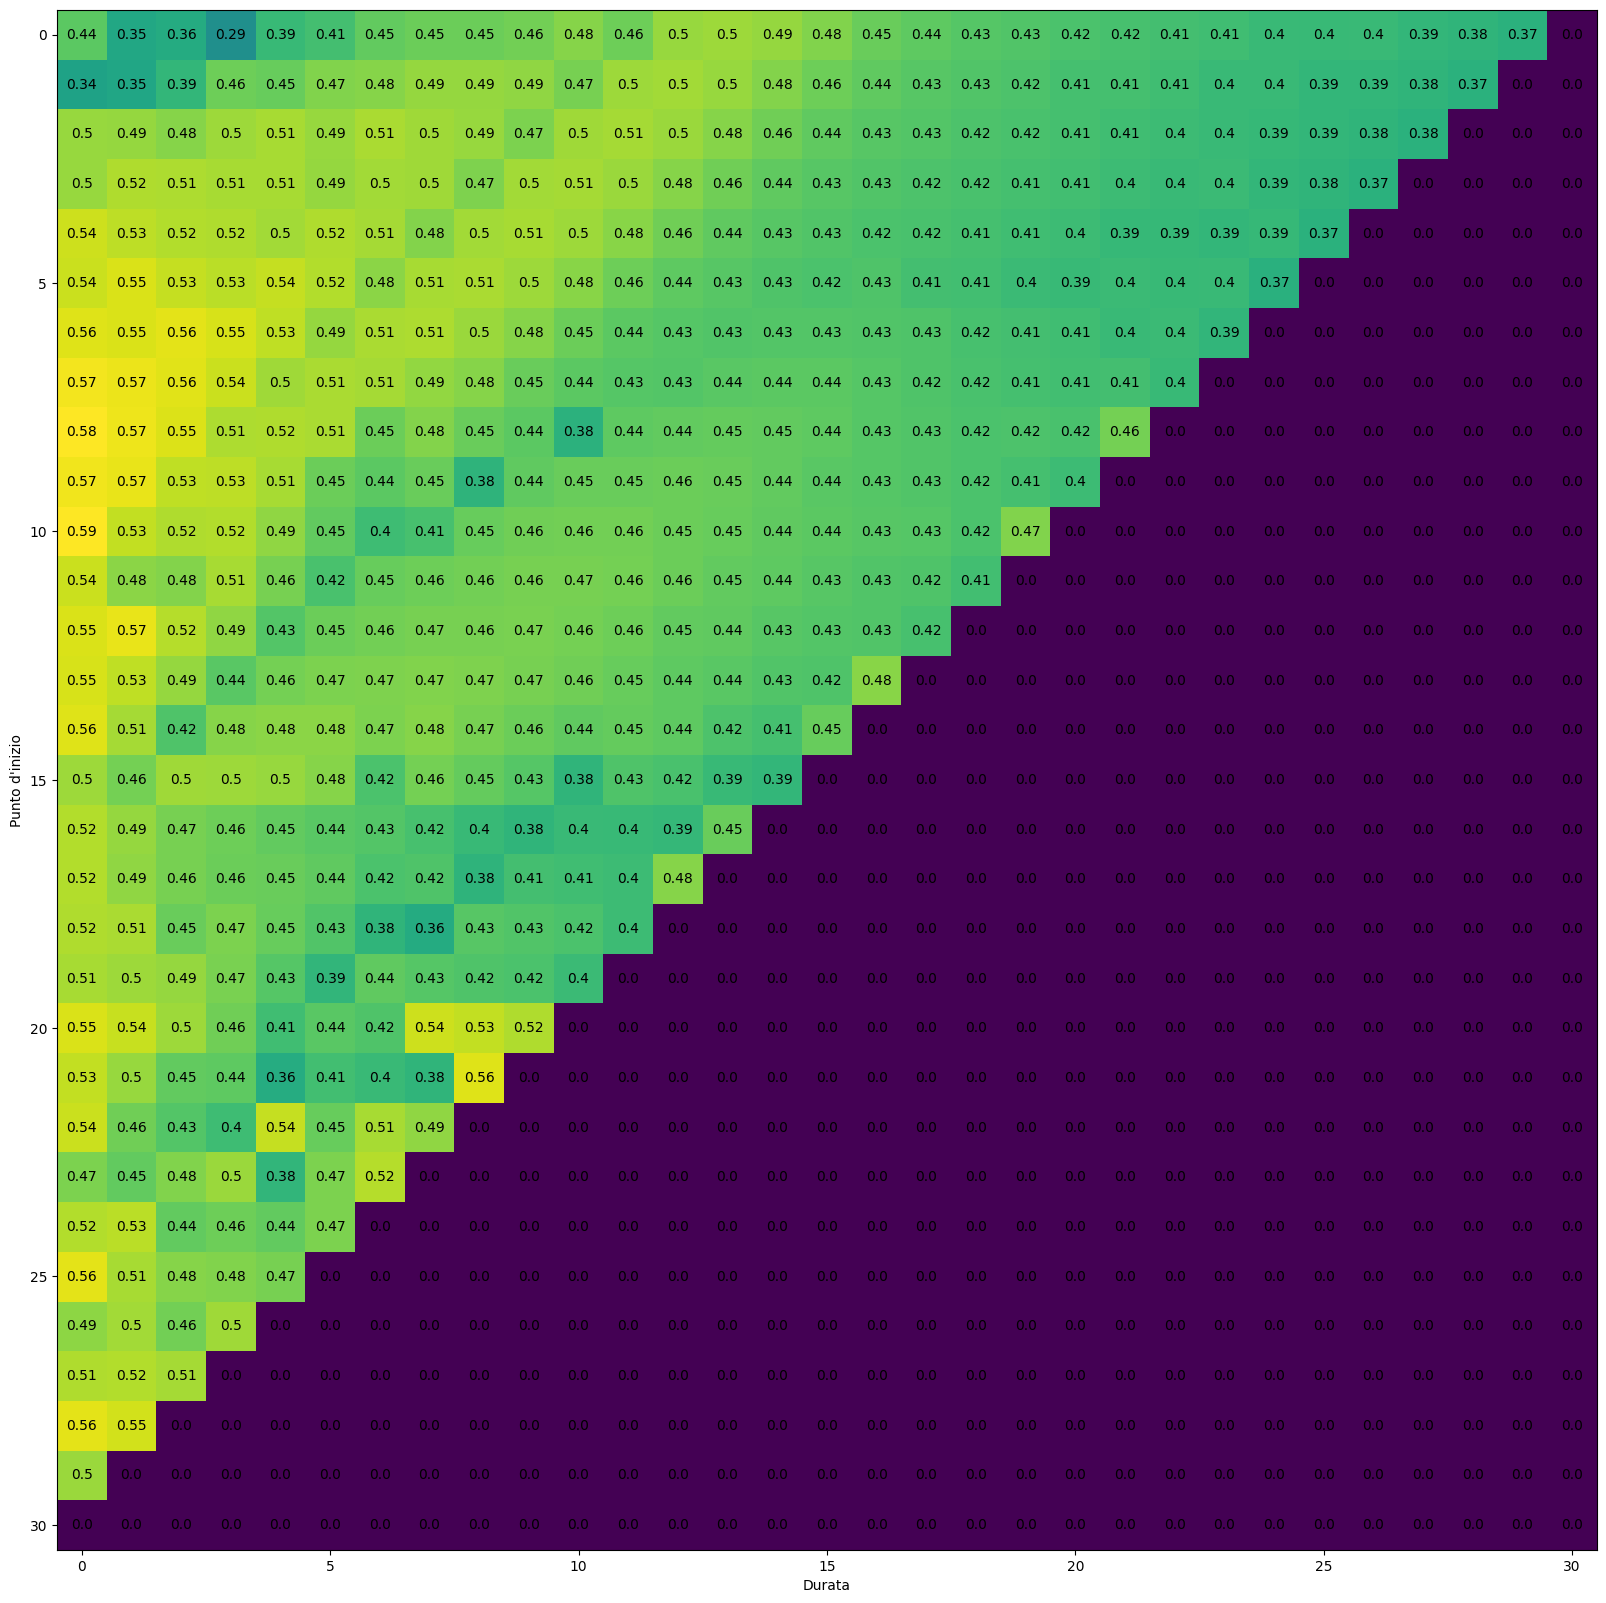

In [6]:

fig, ax = plt.subplots()

image = ax.imshow(matrice_silhoutte)

plt.xlabel("Durata")
plt.ylabel("Punto d'inizio")

fig.set_size_inches(20,20)

for i in range(0,matrice_silhoutte.shape[0]):
    for j in range(0,matrice_silhoutte.shape[1]):
        c = np.round(matrice_silhoutte[i,j],decimals=2)
        ax.text(j, i, str(c), va='center', ha='center')

# Metriche di coesione, deviazione standard

In [21]:
x = int(155/5)
y = int(155/5)

In [8]:
meanStd = np.zeros([x,y,num_cluster])
cluster_deviation = np.zeros([x,y,num_cluster])
number_elements = np.zeros([x,y,num_cluster],dtype='uint32')
for i in range(x):
    for j in range(y):
        if rese_total[i,j,0] is not None:
            for k in range(num_cluster):
                mean = np.mean(rese_total[i,j,k])
                sum = 0
                for resa in rese_total[i,j,k]:
                    sum += (resa-mean)**2
                number_elements[i,j,k] = len(rese_total[i,j,k])
                if number_elements[i,j,k] > 1:
                    cluster_deviation[i,j,k] = np.sqrt(sum/(number_elements[i,j,k]-1))
                else:
                    cluster_deviation[i,j,k] = 1
                    
            meanStd[i,j] = cluster_deviation[i,j].mean()

        

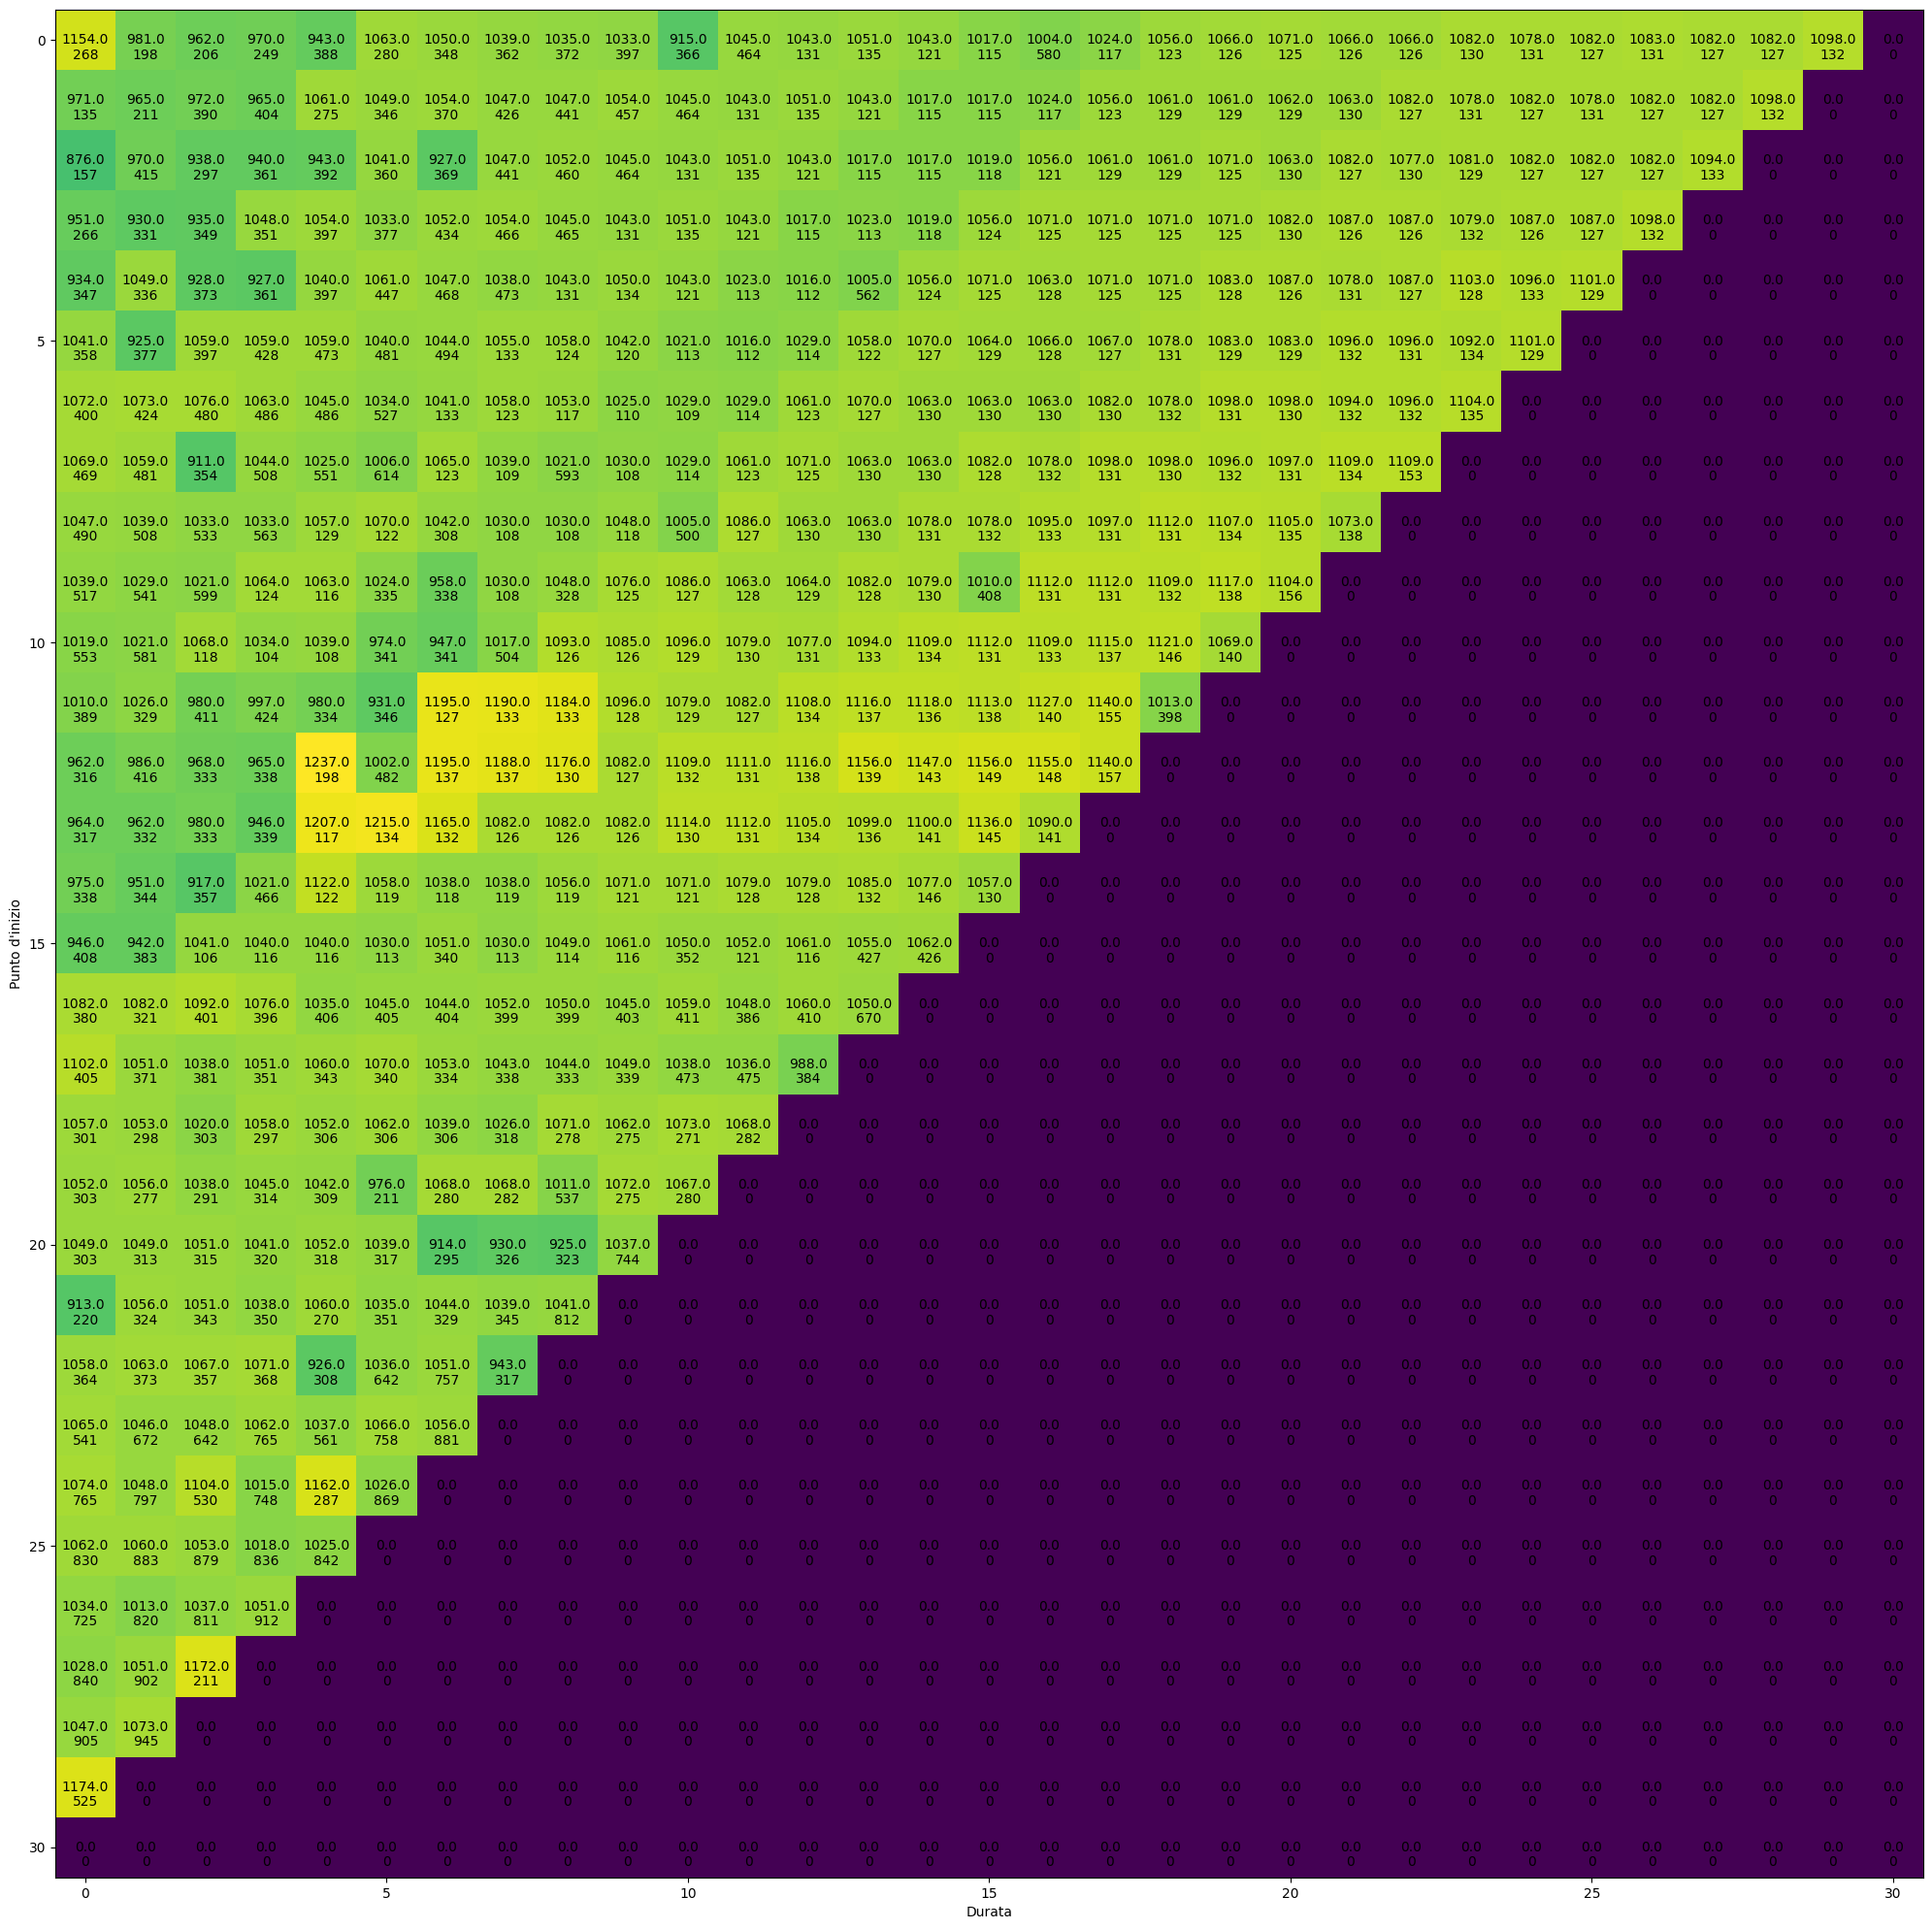

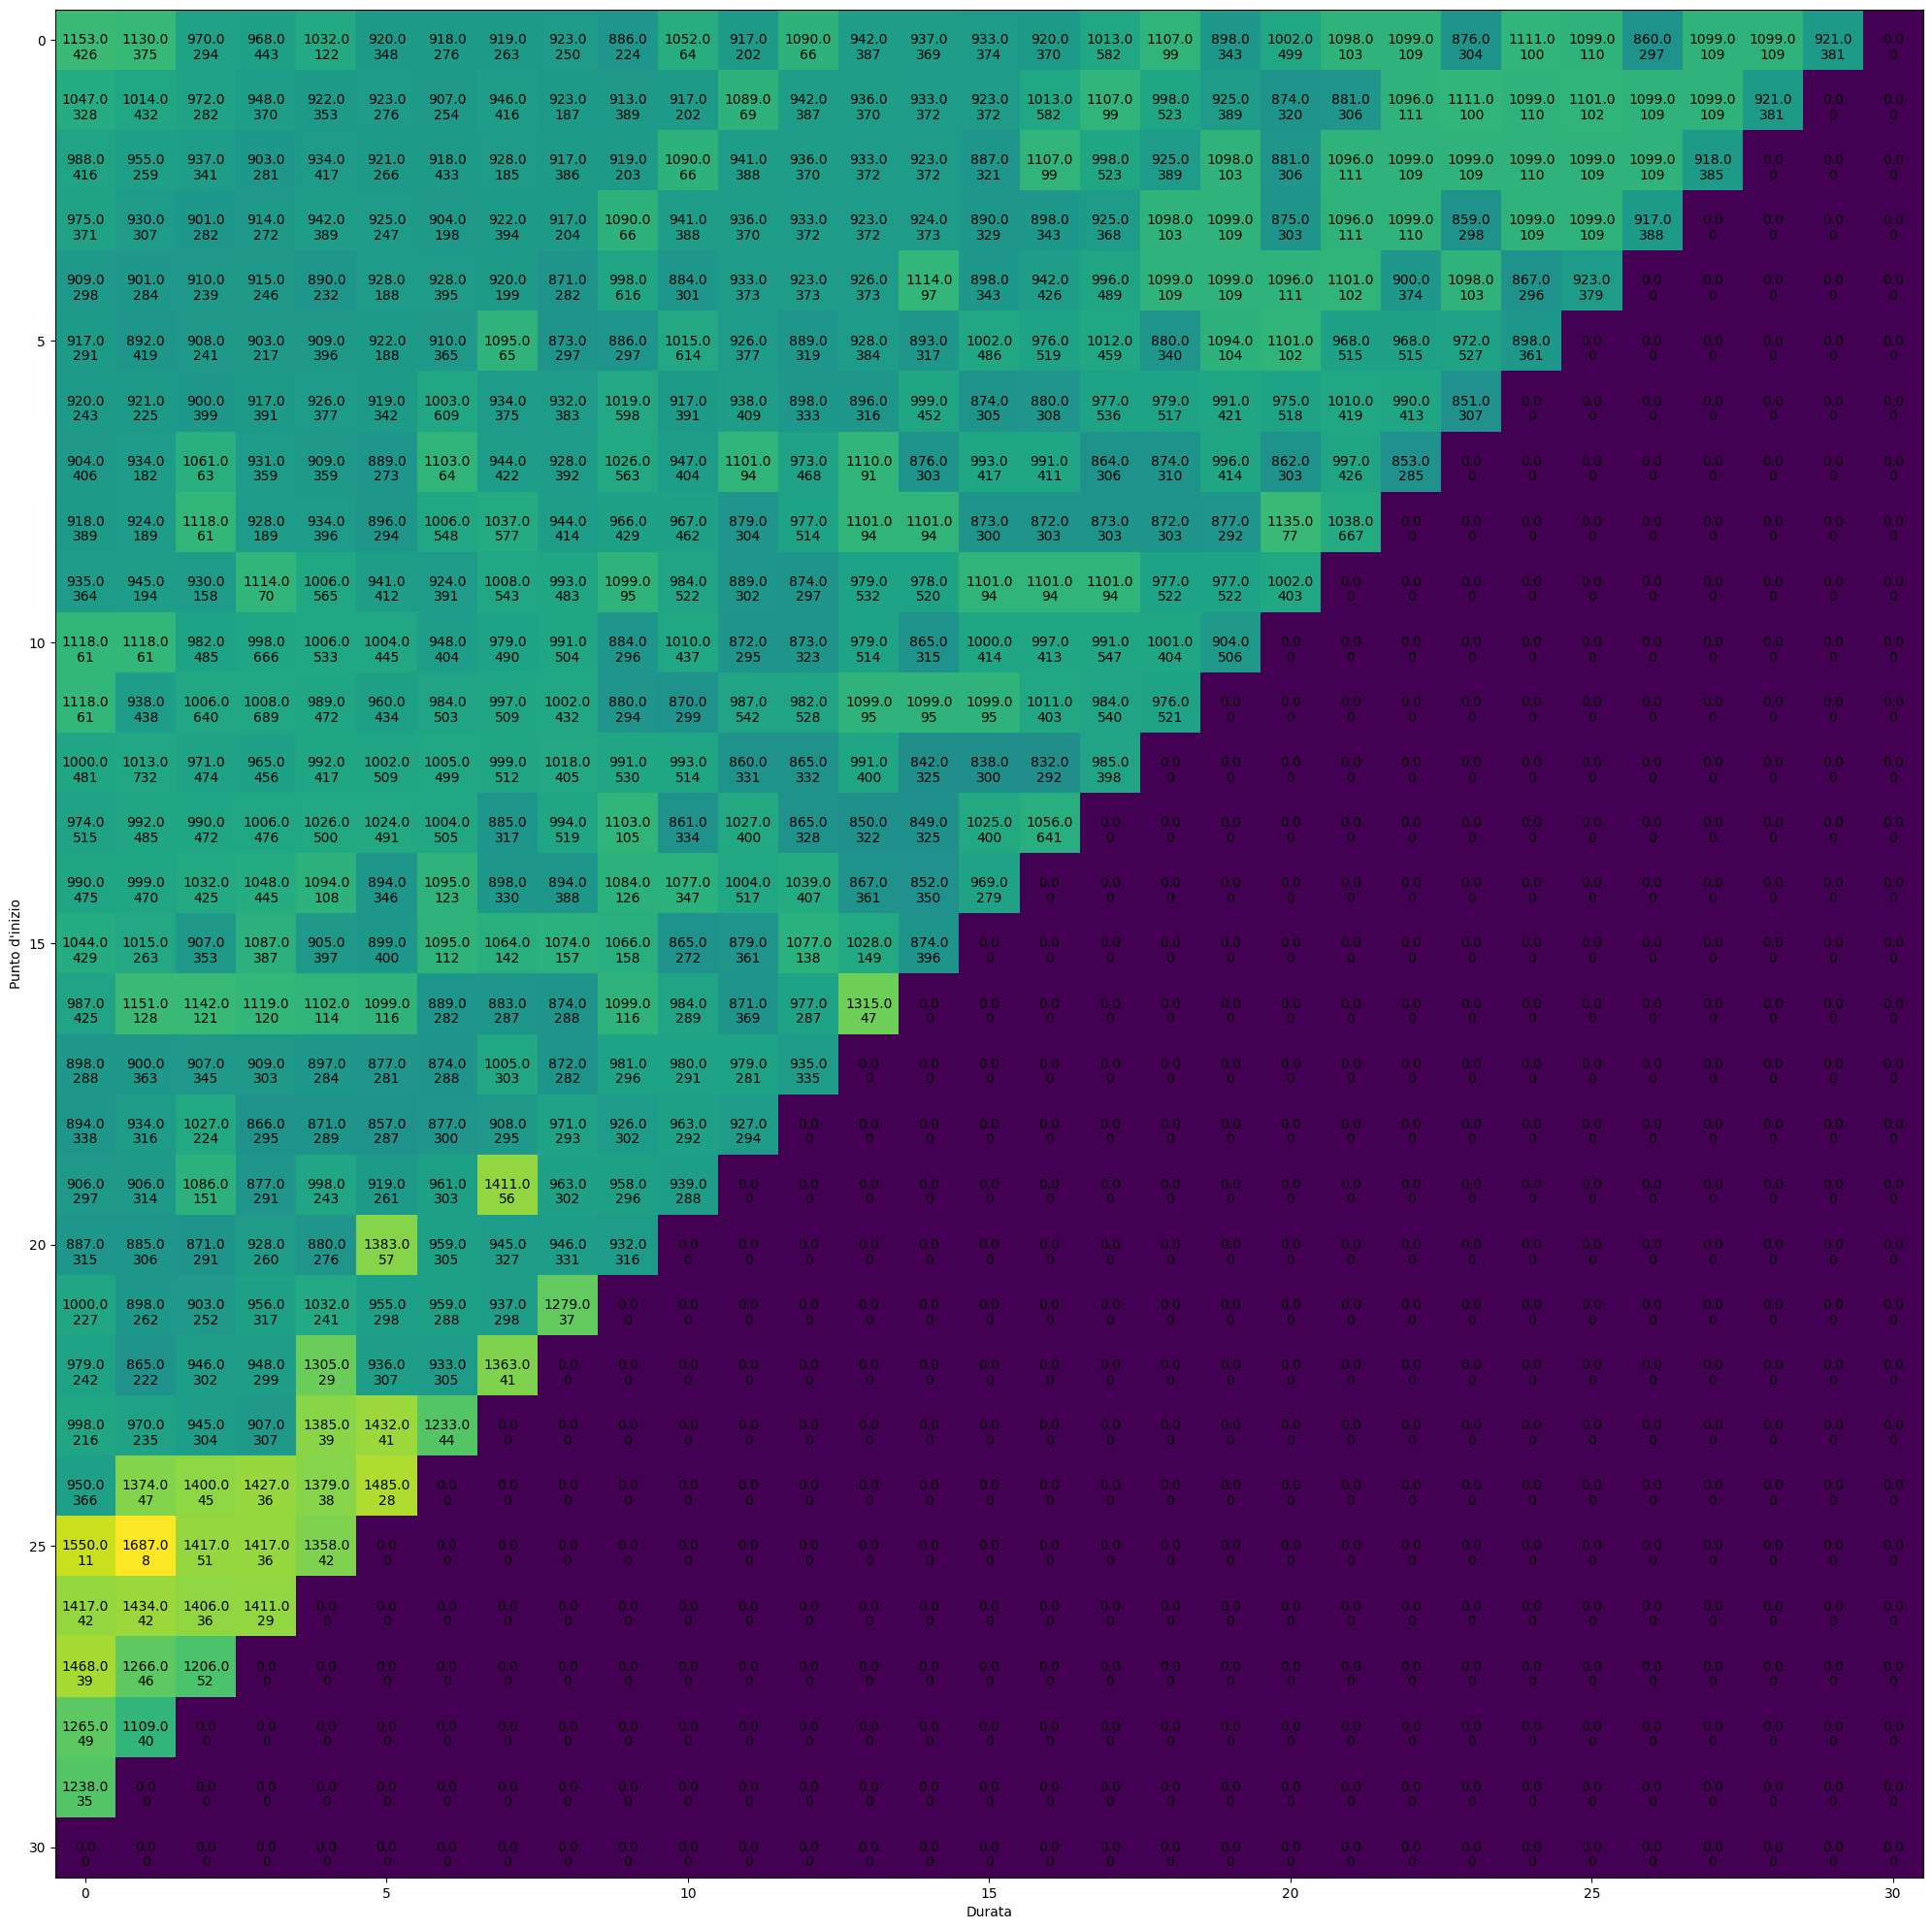

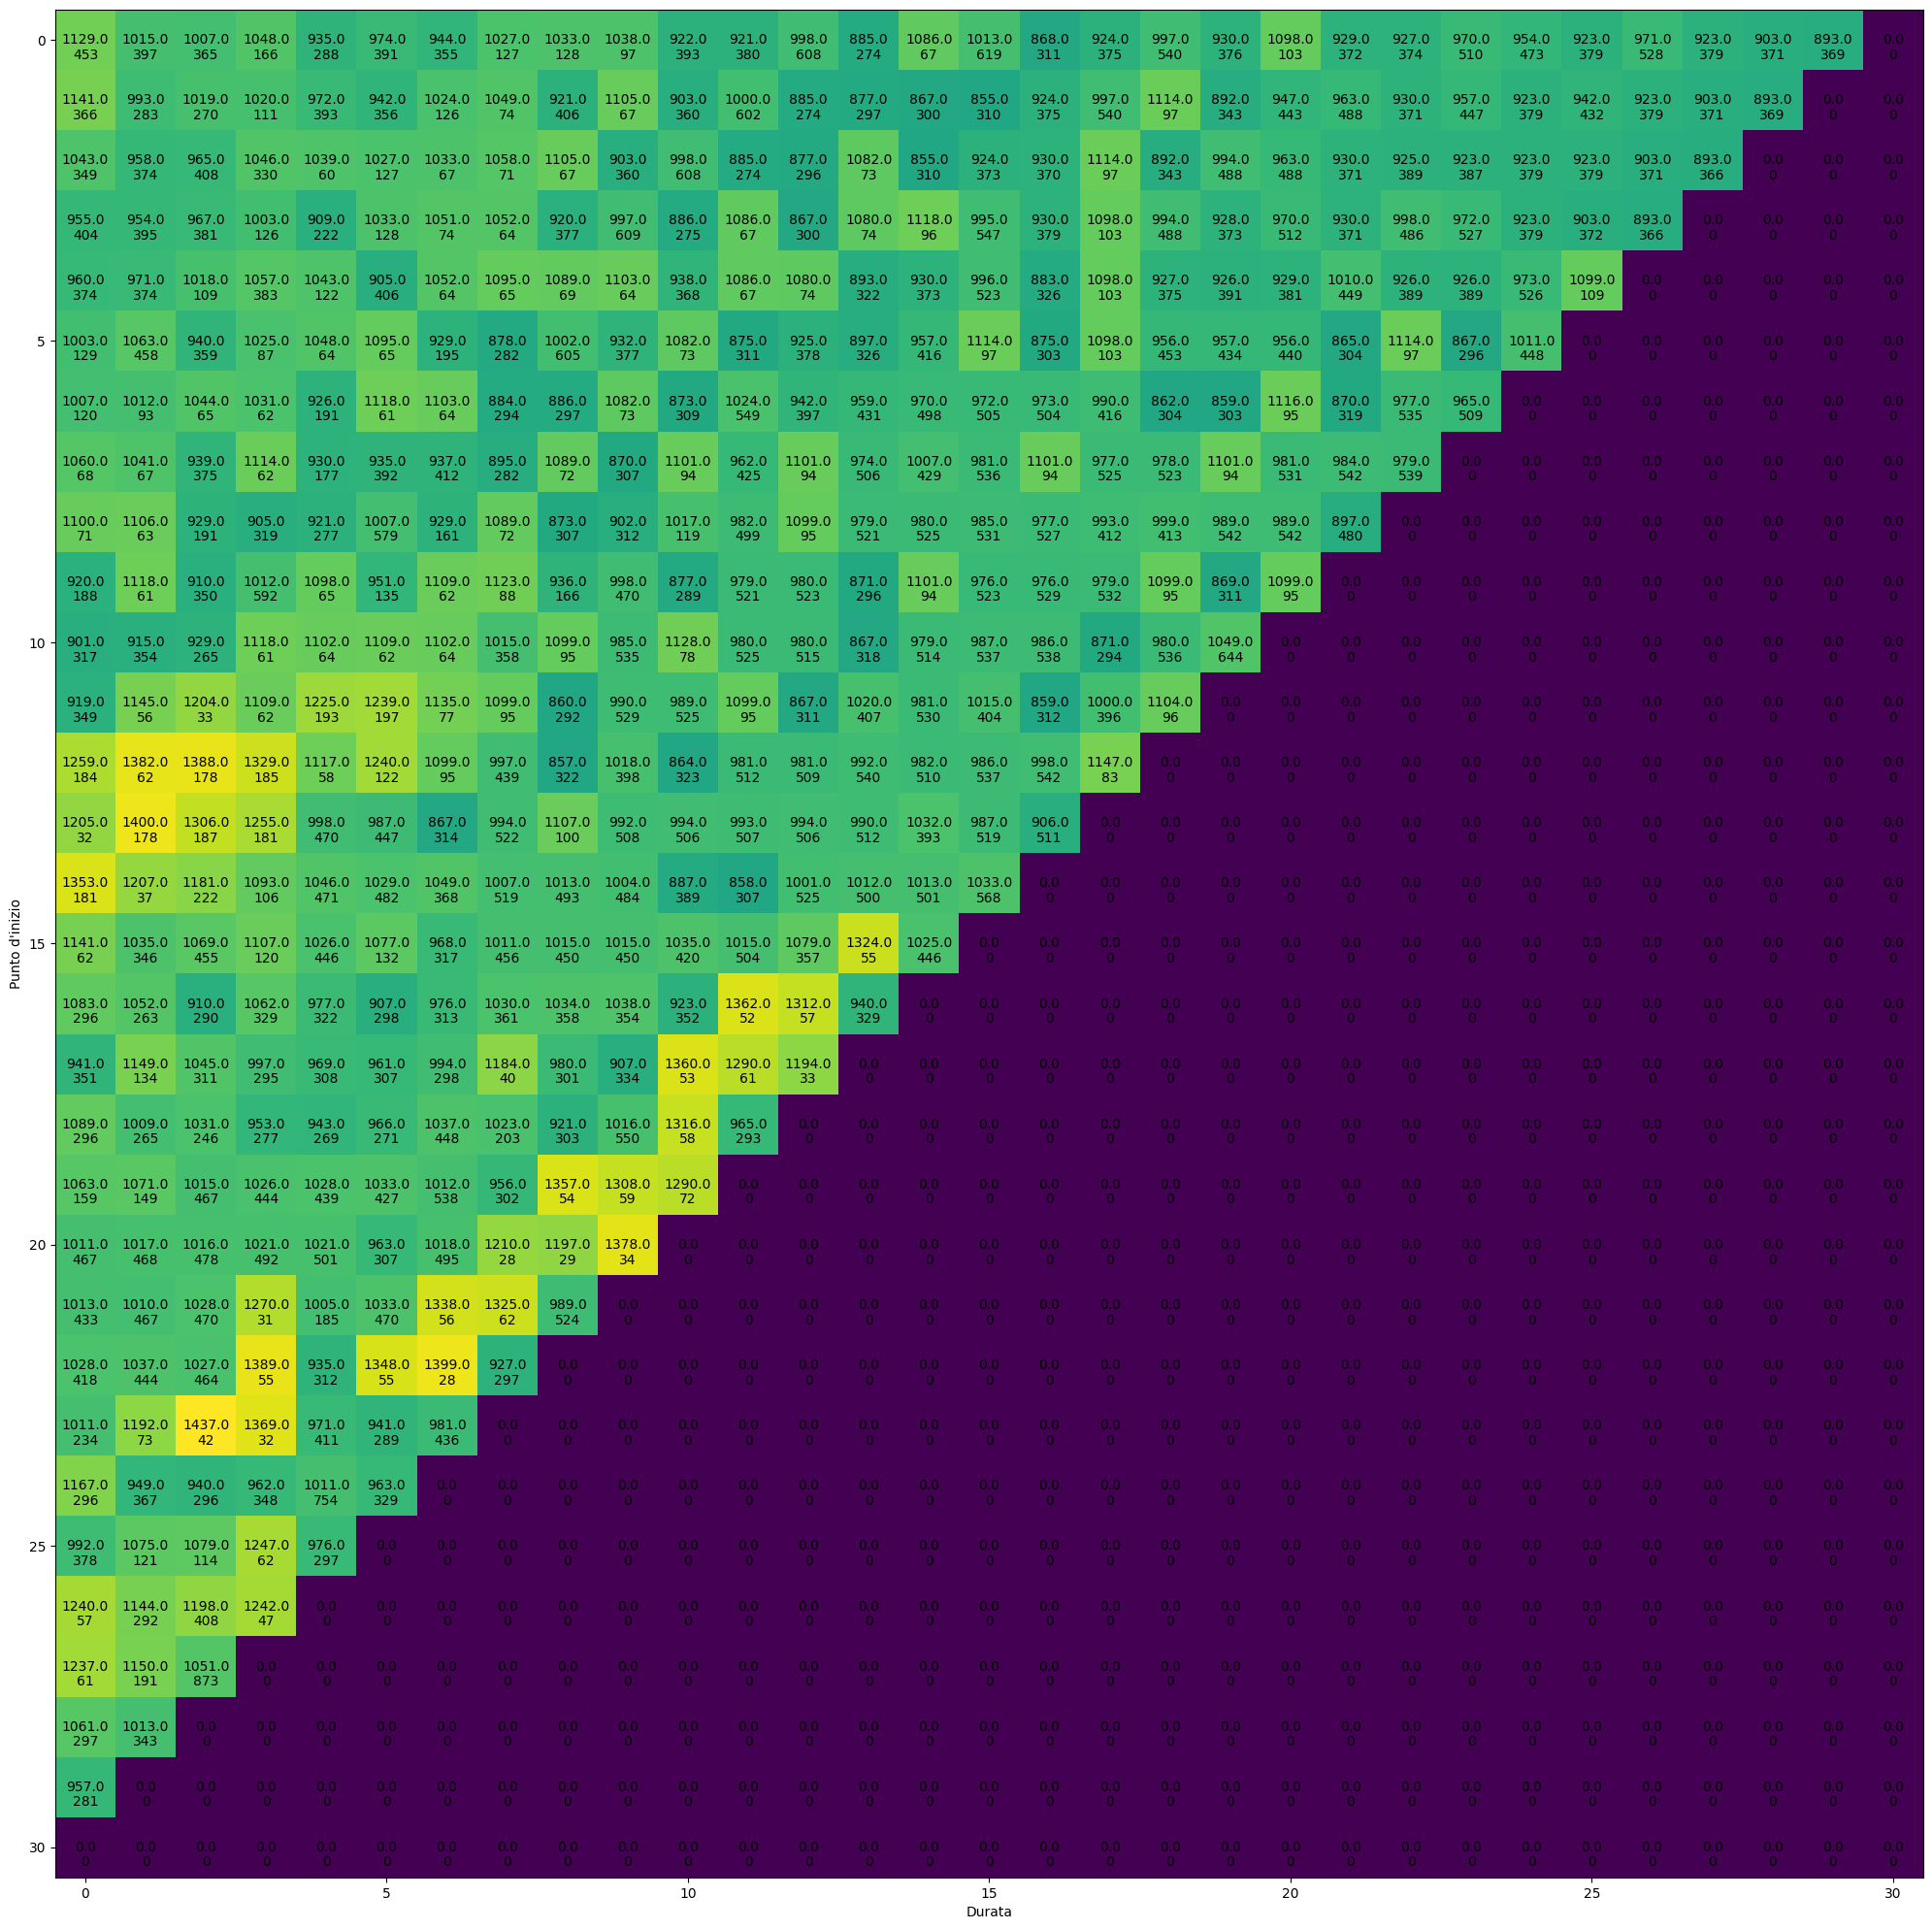

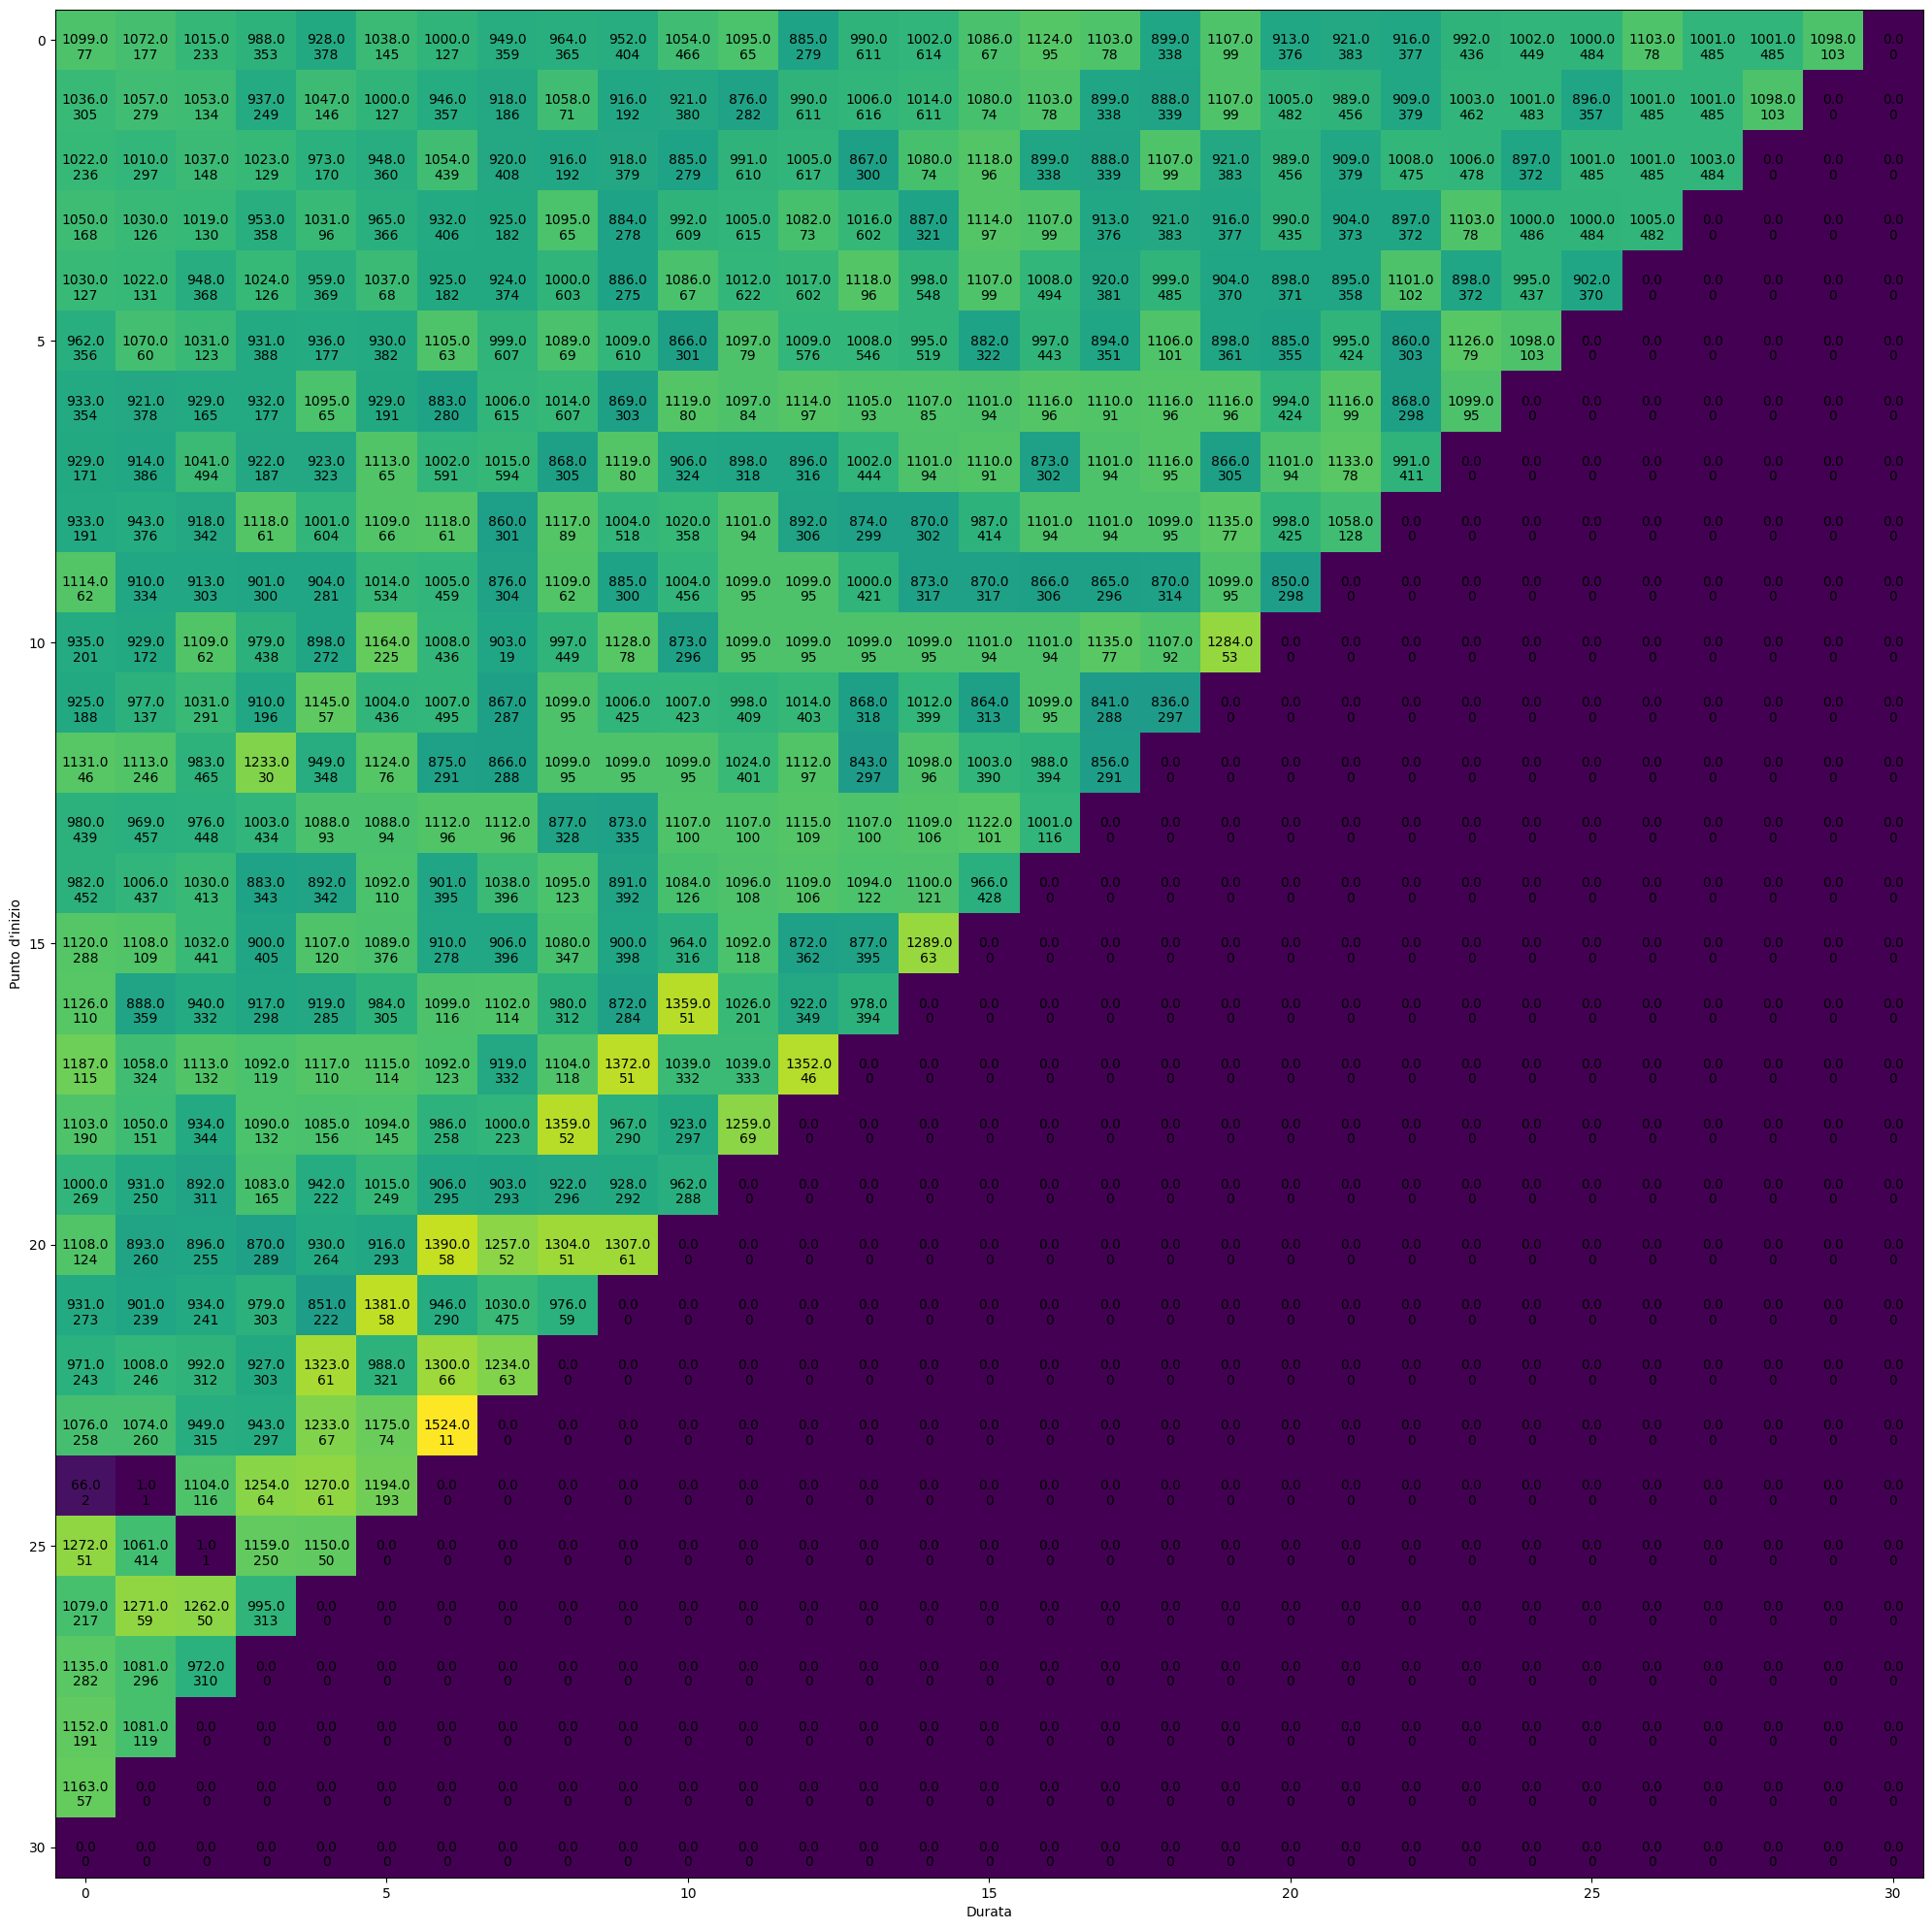

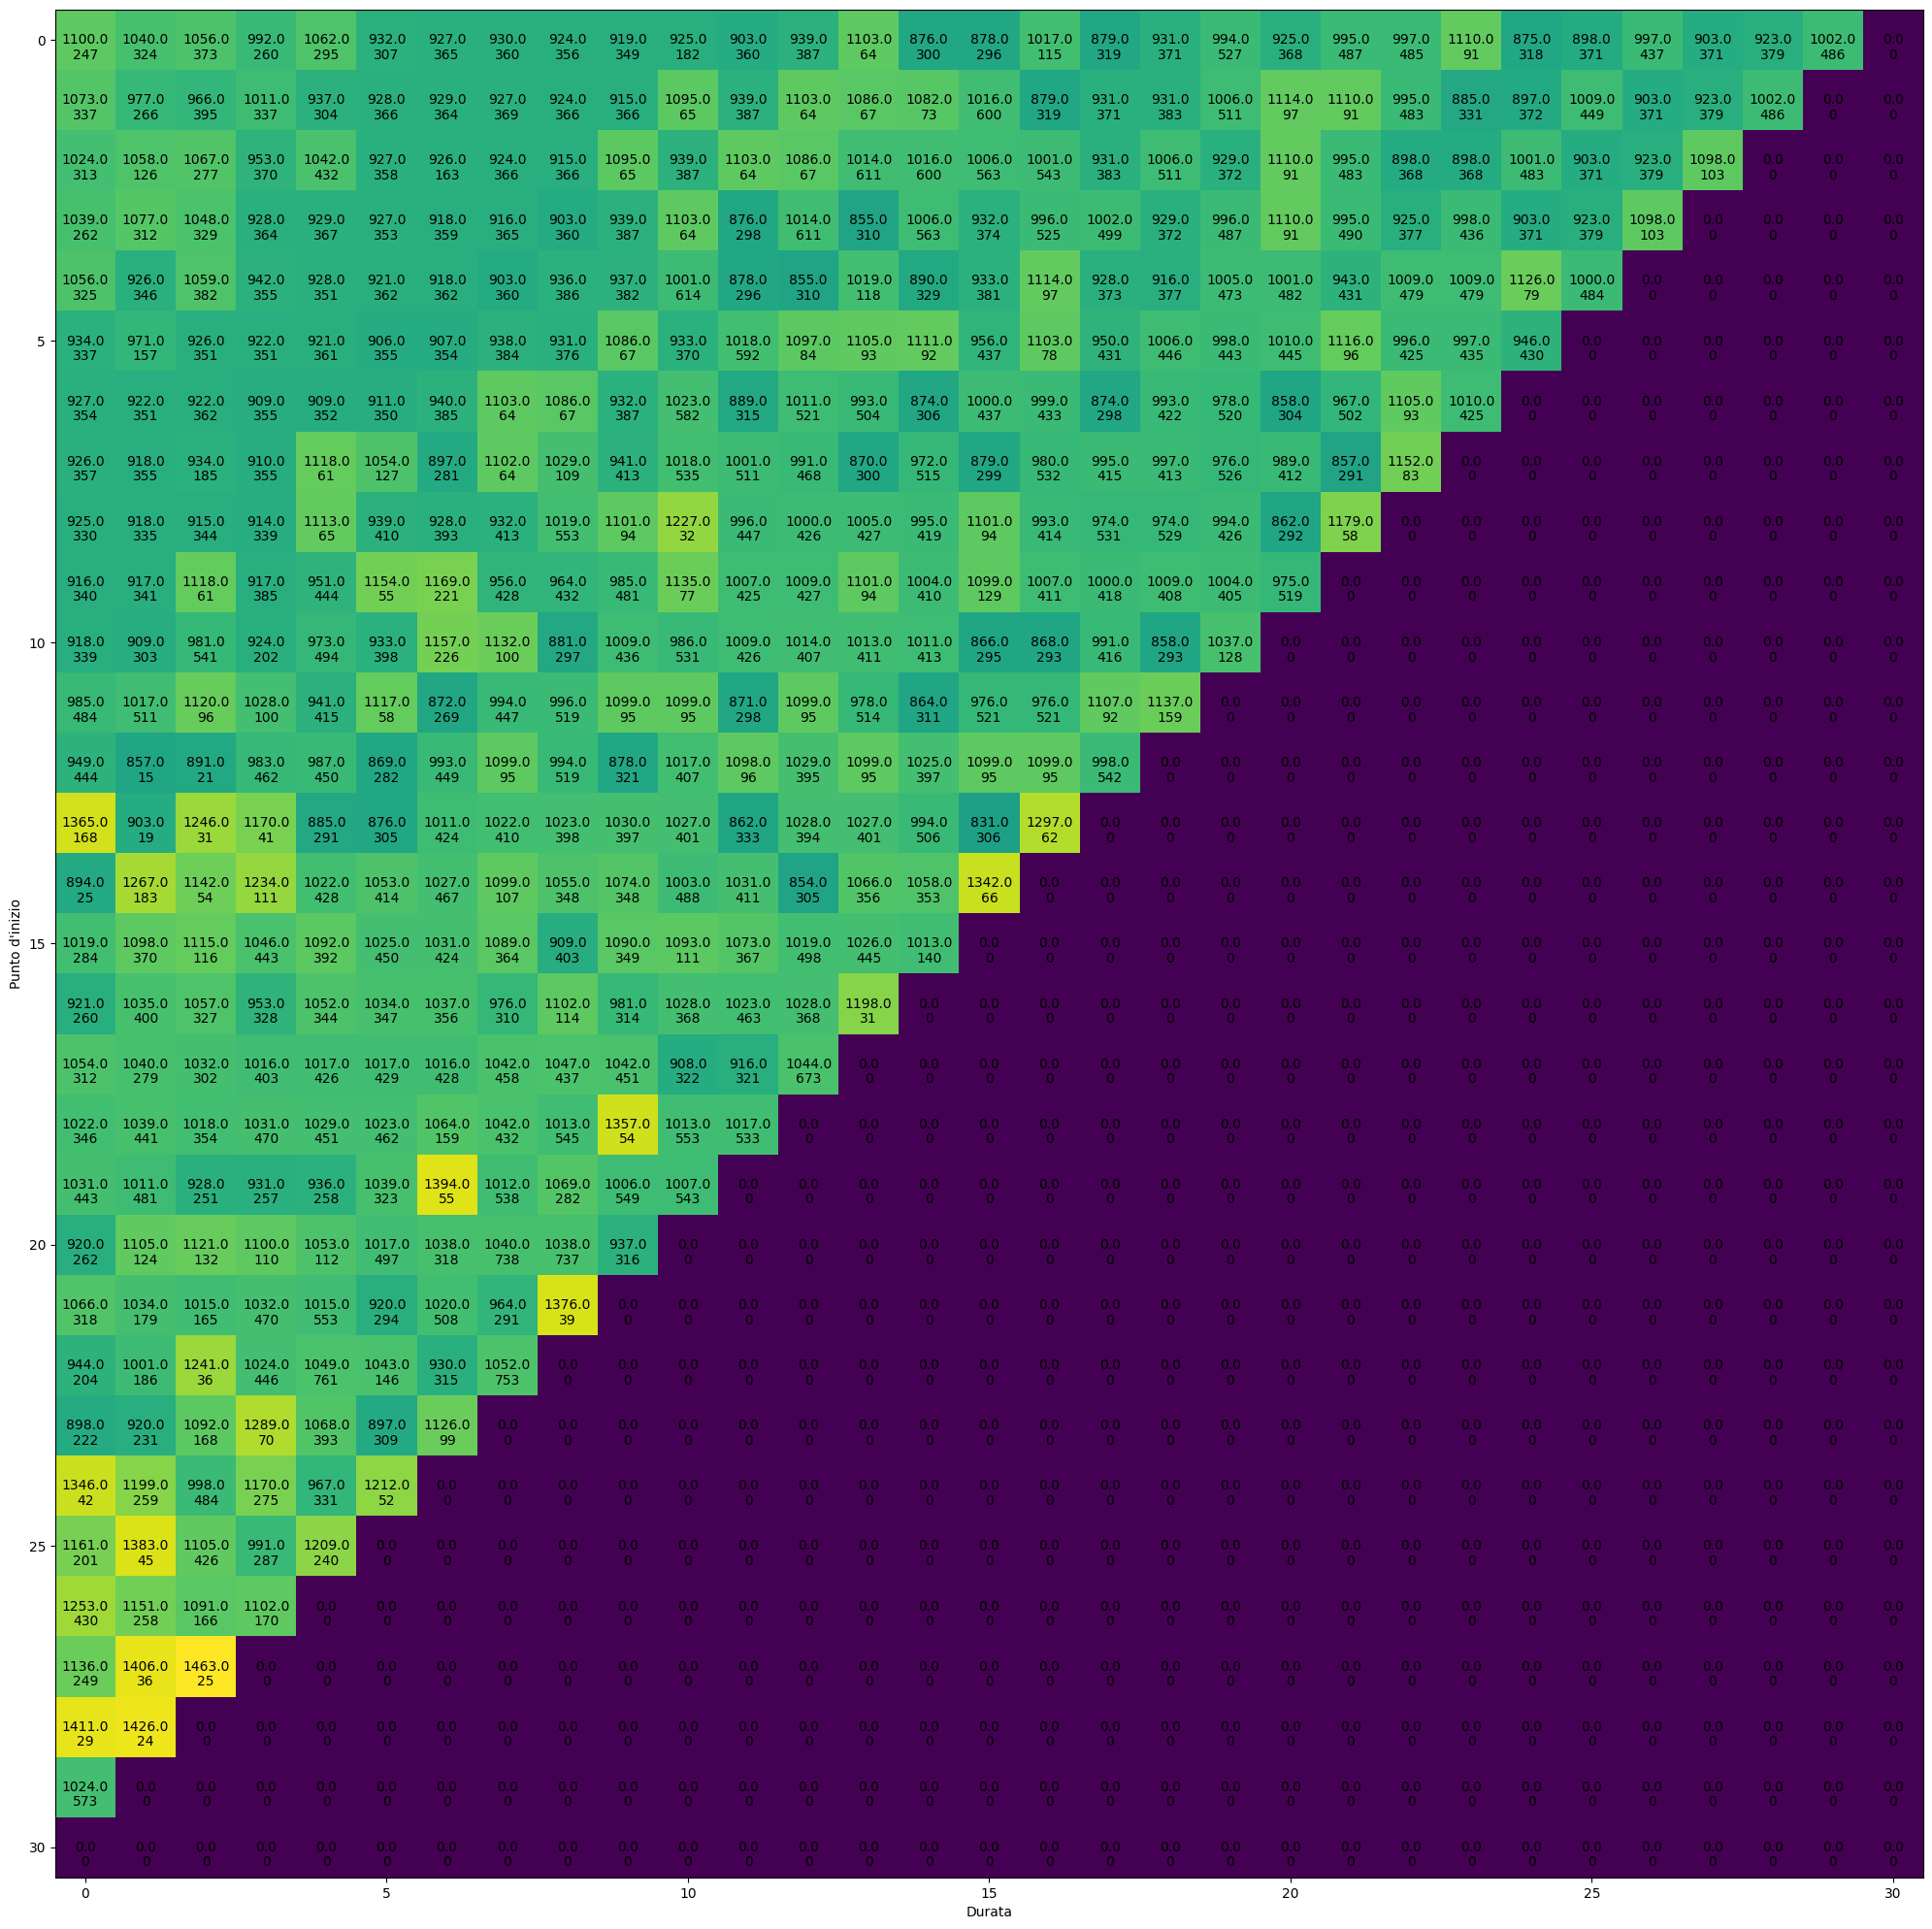

In [9]:
# Andiamo a stampare le deviazioni standard di tutti i cluster 

for p in range(0,num_cluster):
    
    fig, ax = plt.subplots()

    image = ax.imshow(cluster_deviation[:,:,p])


    plt.xlabel("Durata")
    plt.ylabel("Punto d'inizio")

    fig.set_size_inches(25,25)
    for i in range(0,cluster_deviation.shape[0]):
        for j in range(0,cluster_deviation.shape[1]):
            c = np.round(cluster_deviation[i,j,p],decimals=0)
            #c1 = np.round(number_elements[i,j,p])
            ax.text(j, i, str(c), va='center', ha='center')
            ax.text(j,(i+0.25),str(number_elements[i,j,p]),va='center', ha='center')

# Analisi della separazione con somma delle distanze tra un i punti di un cluster e tutti gli altri

In [22]:
# Altra metrica di separazione 

sum_separation = np.zeros([x,y,num_cluster])
    
for i in range(x):
    for j in range(y):
        if rese_total[i,j,0] is not None:
            for a,resaj in zip(rese_total[i,j,:],range(num_cluster)):
                sum = 0
                for b,resai in zip(rese_total[i,j,:],range(num_cluster)):
                    if(resai == resaj):
                        continue
                    for c in a:
                        for d in b:
                            sum += abs(c-d)
                sum_separation[i,j,resaj] = ((sum/(len(newResa3)-len(a))))/len(a)

        

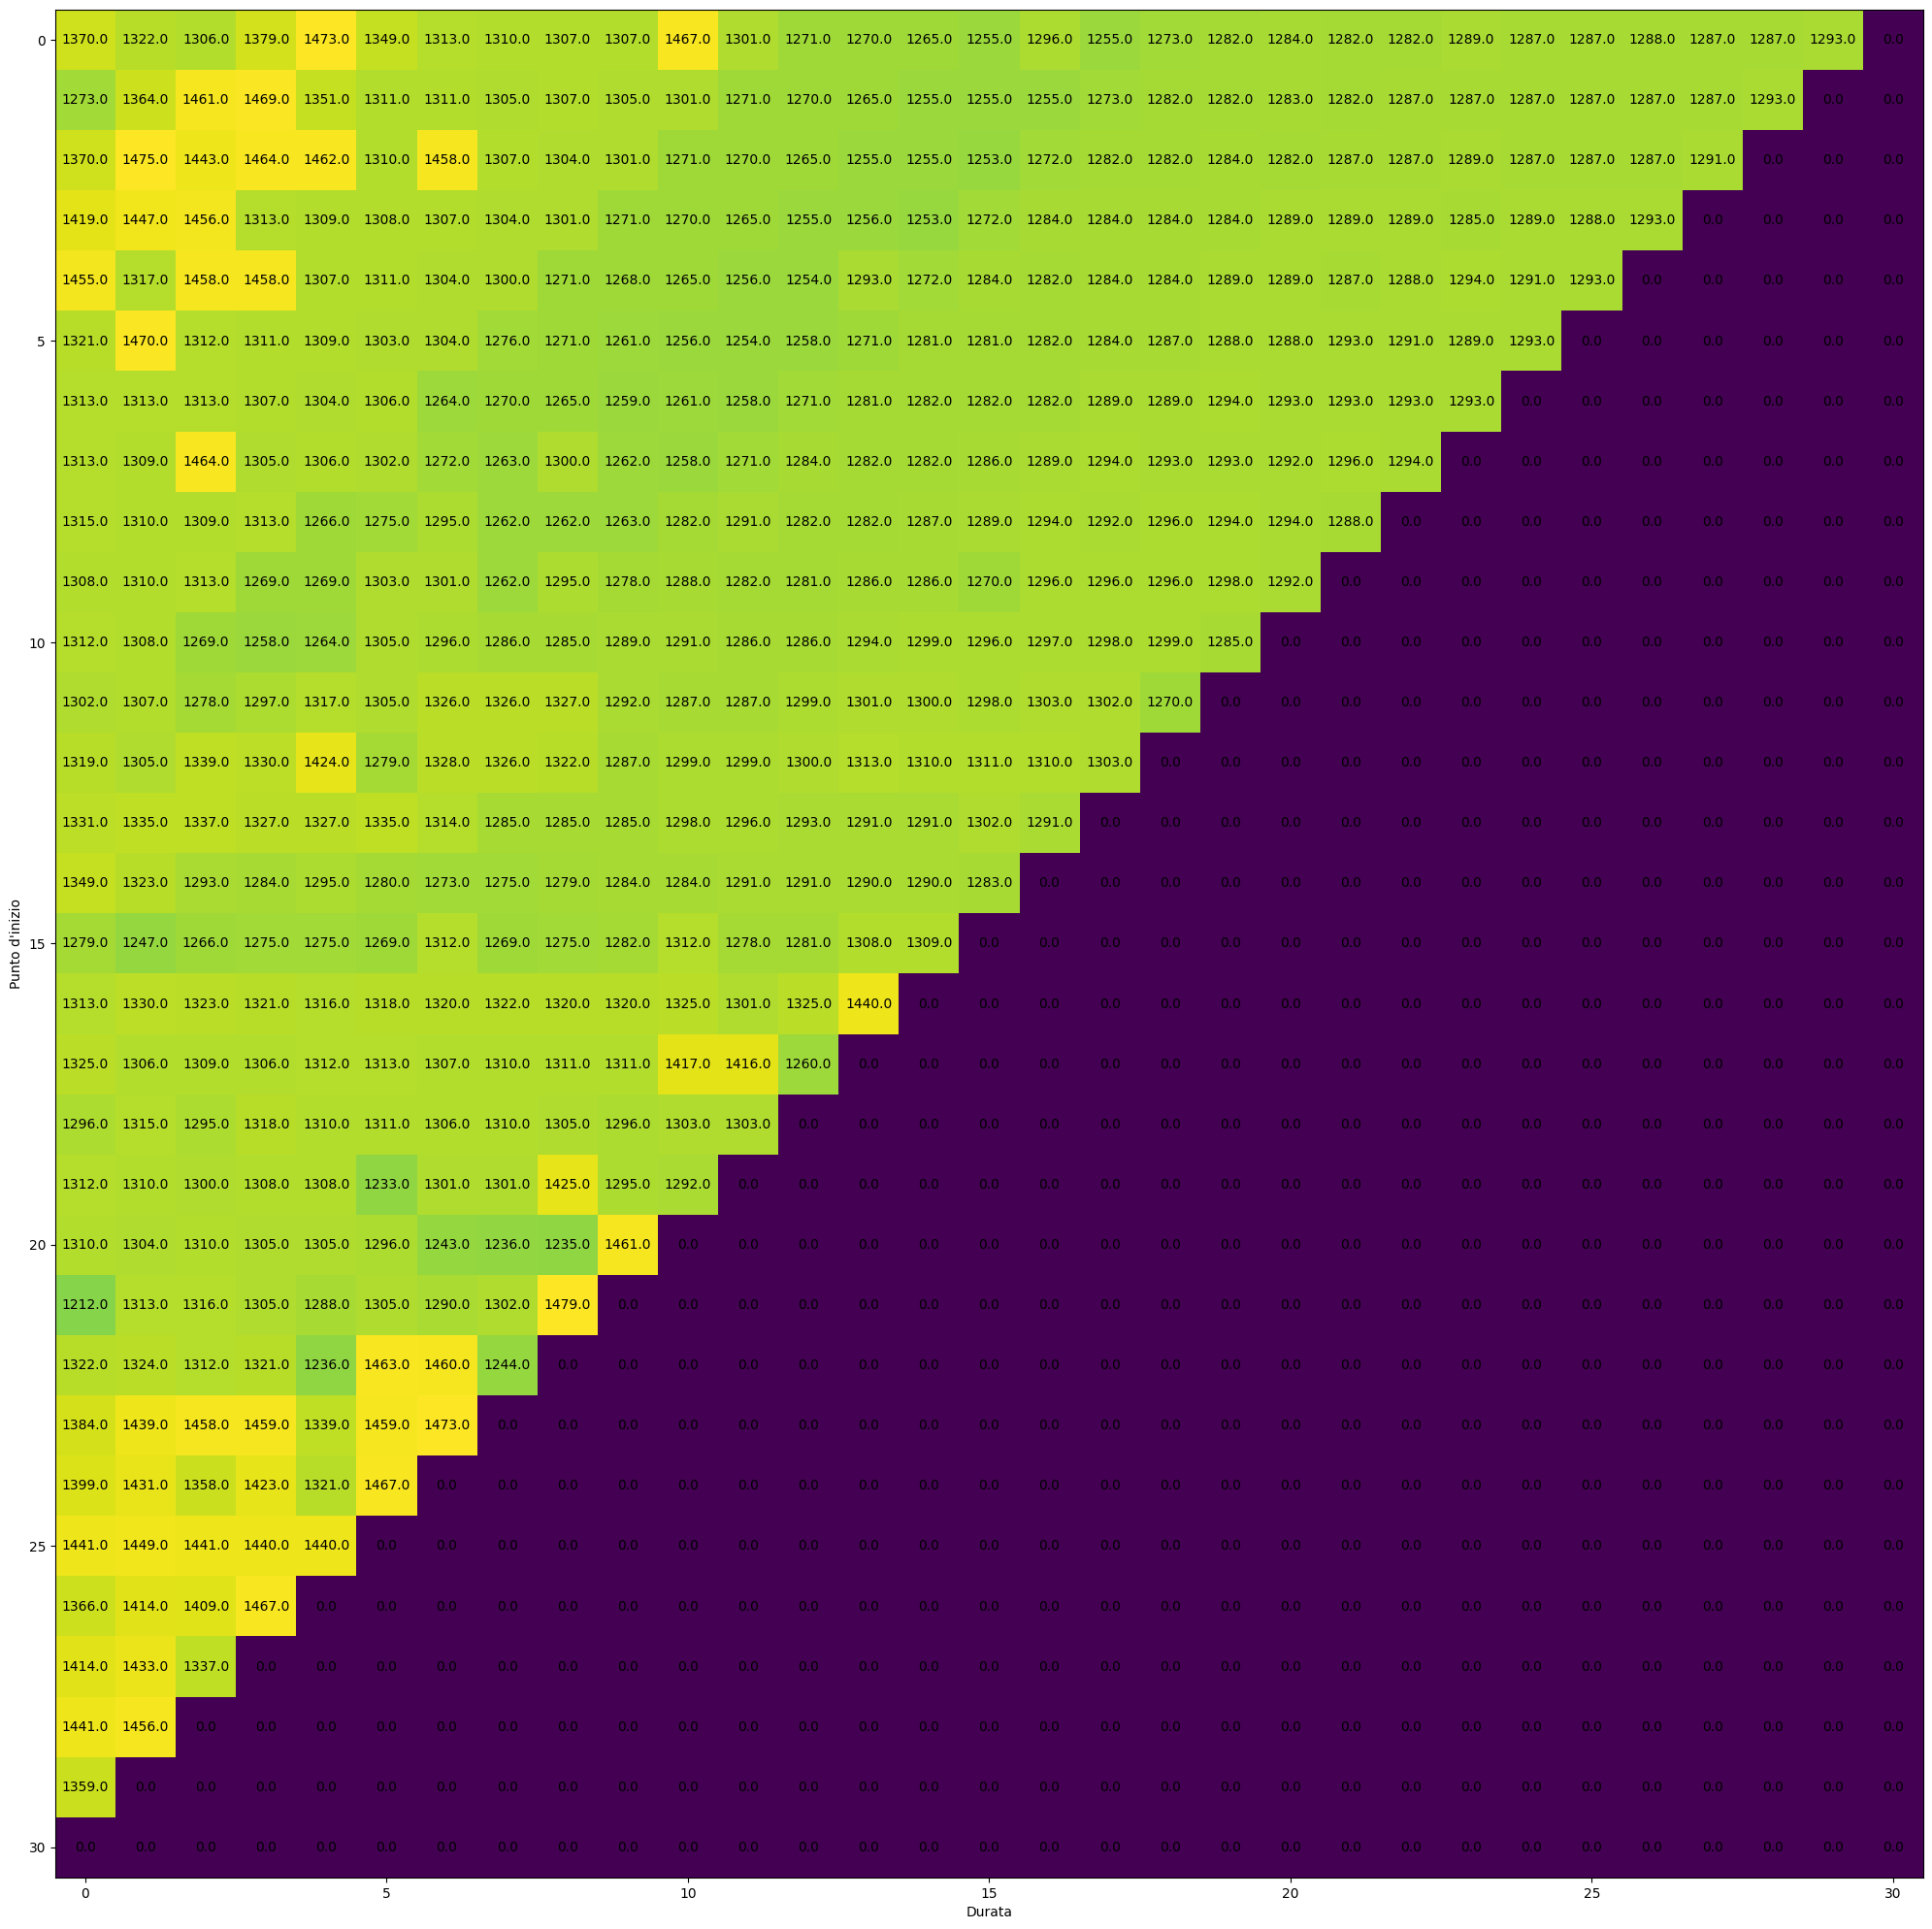

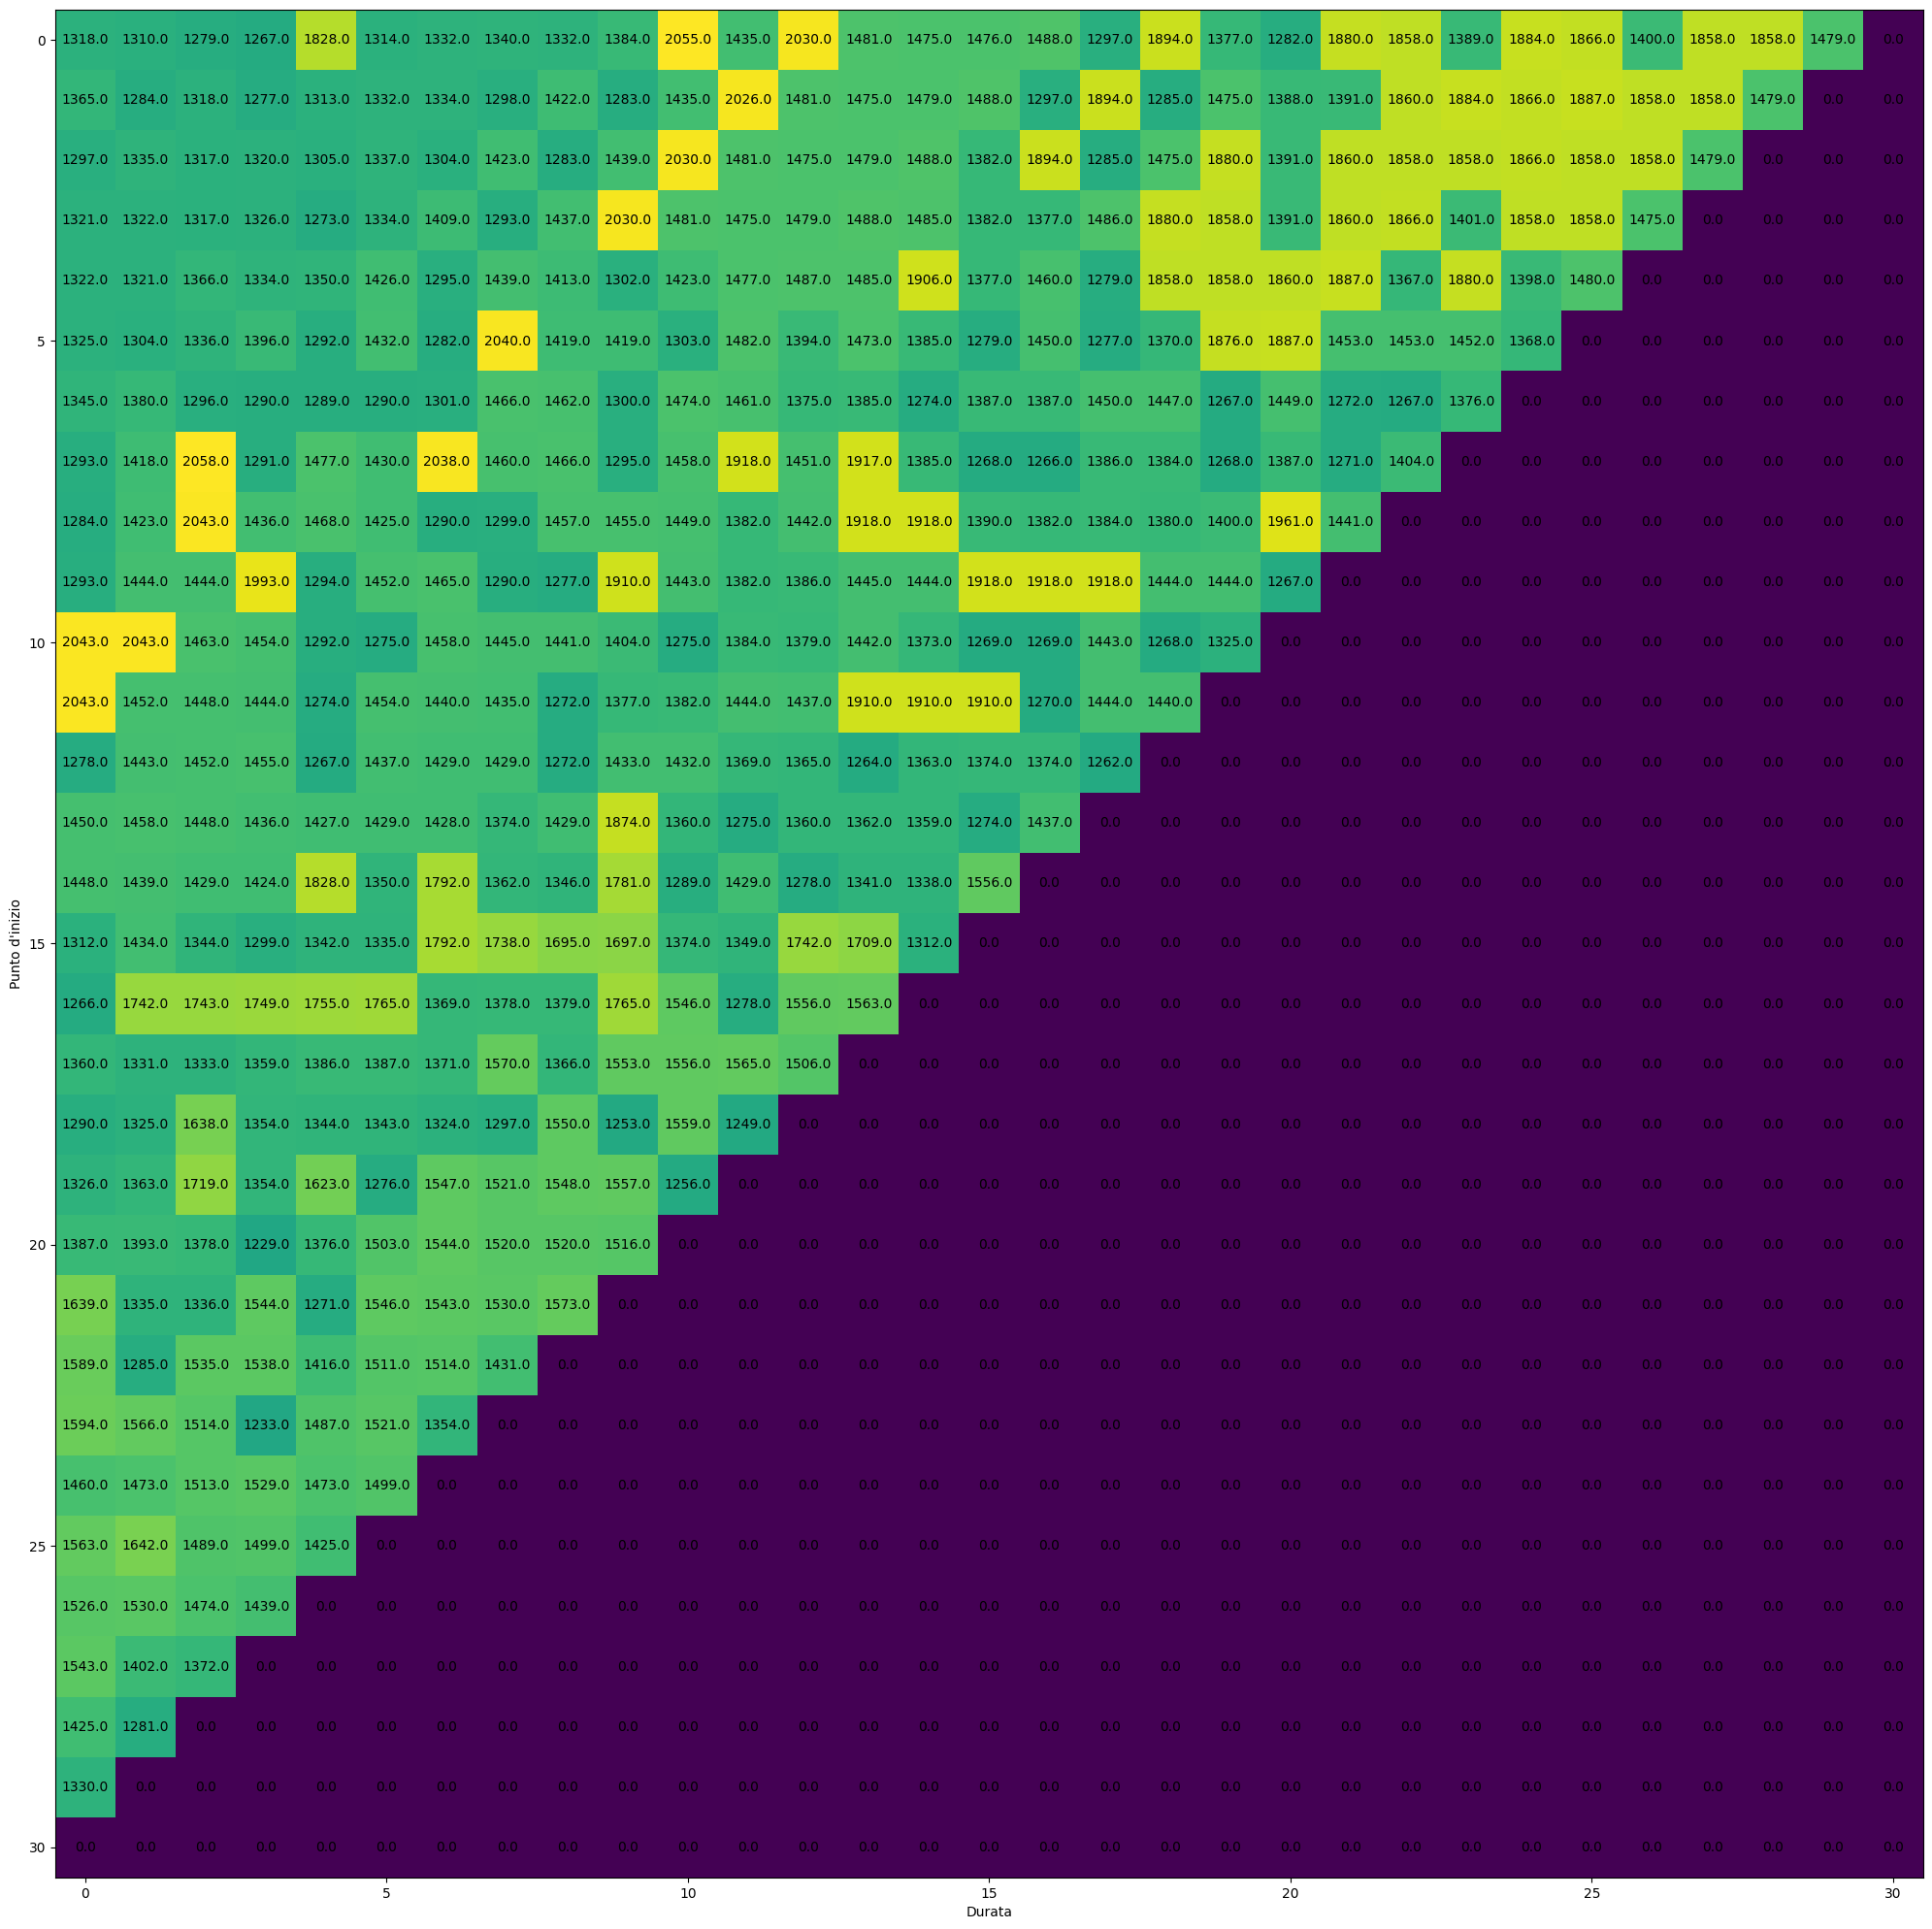

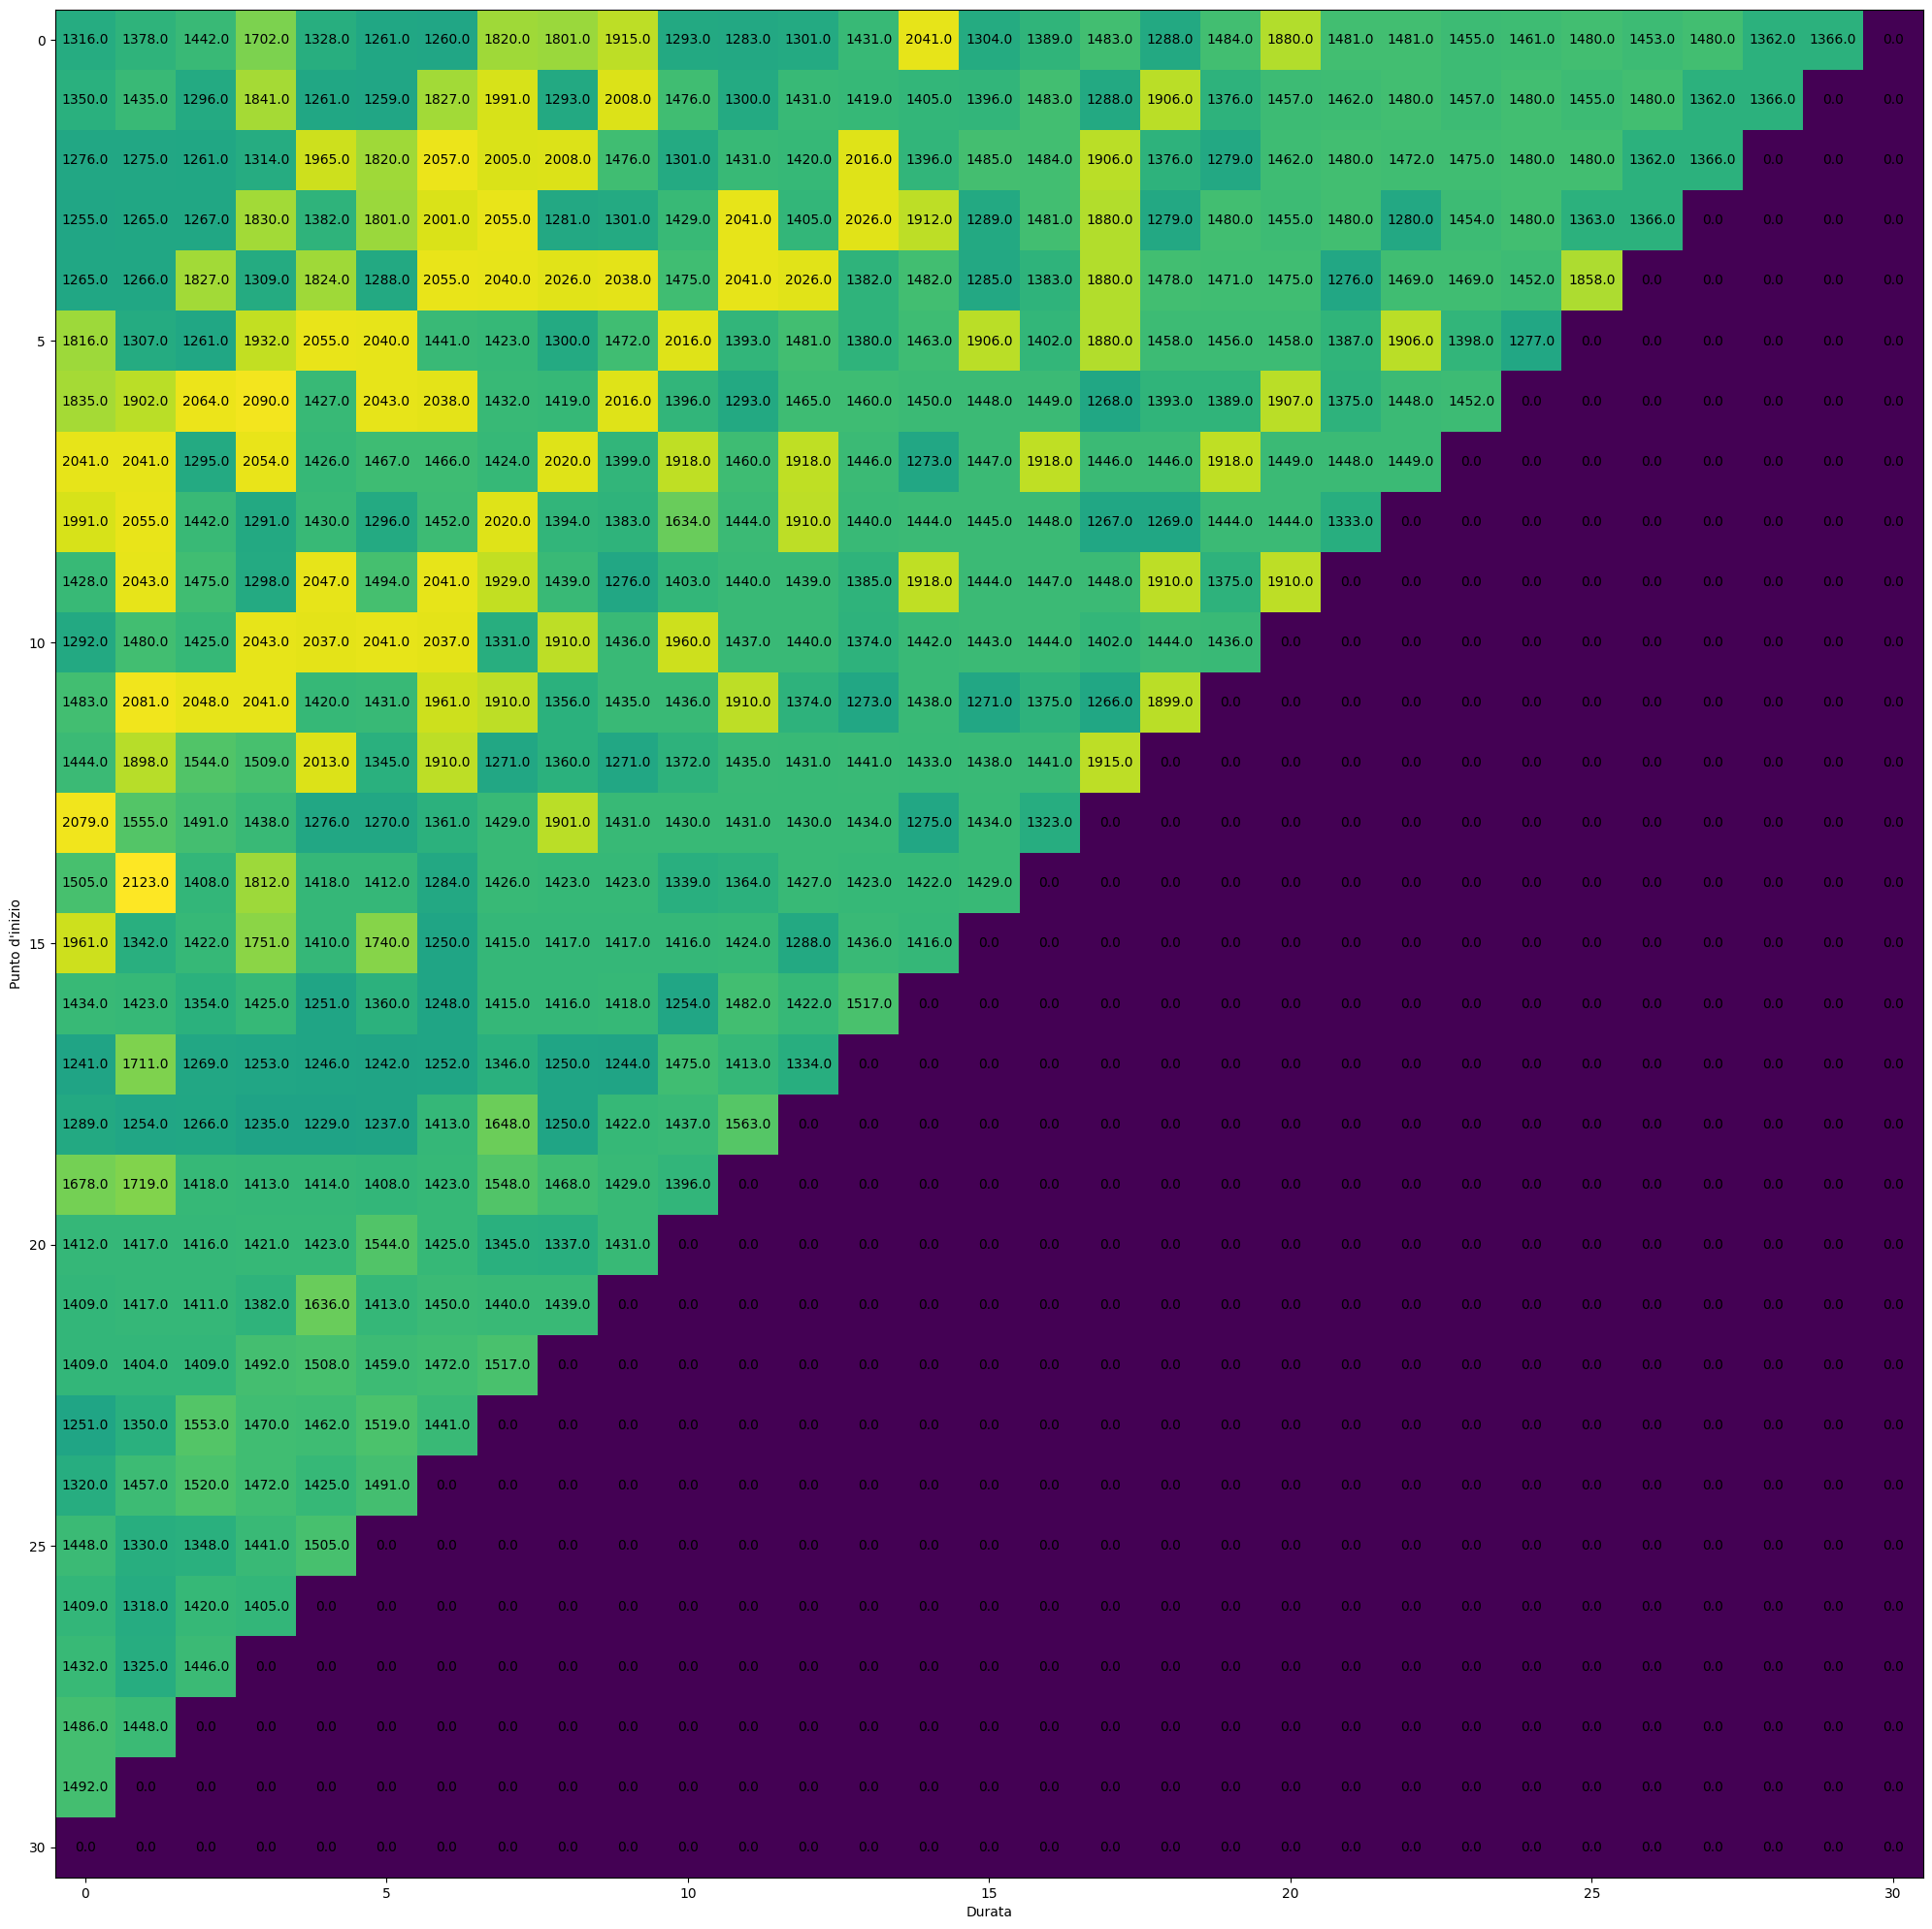

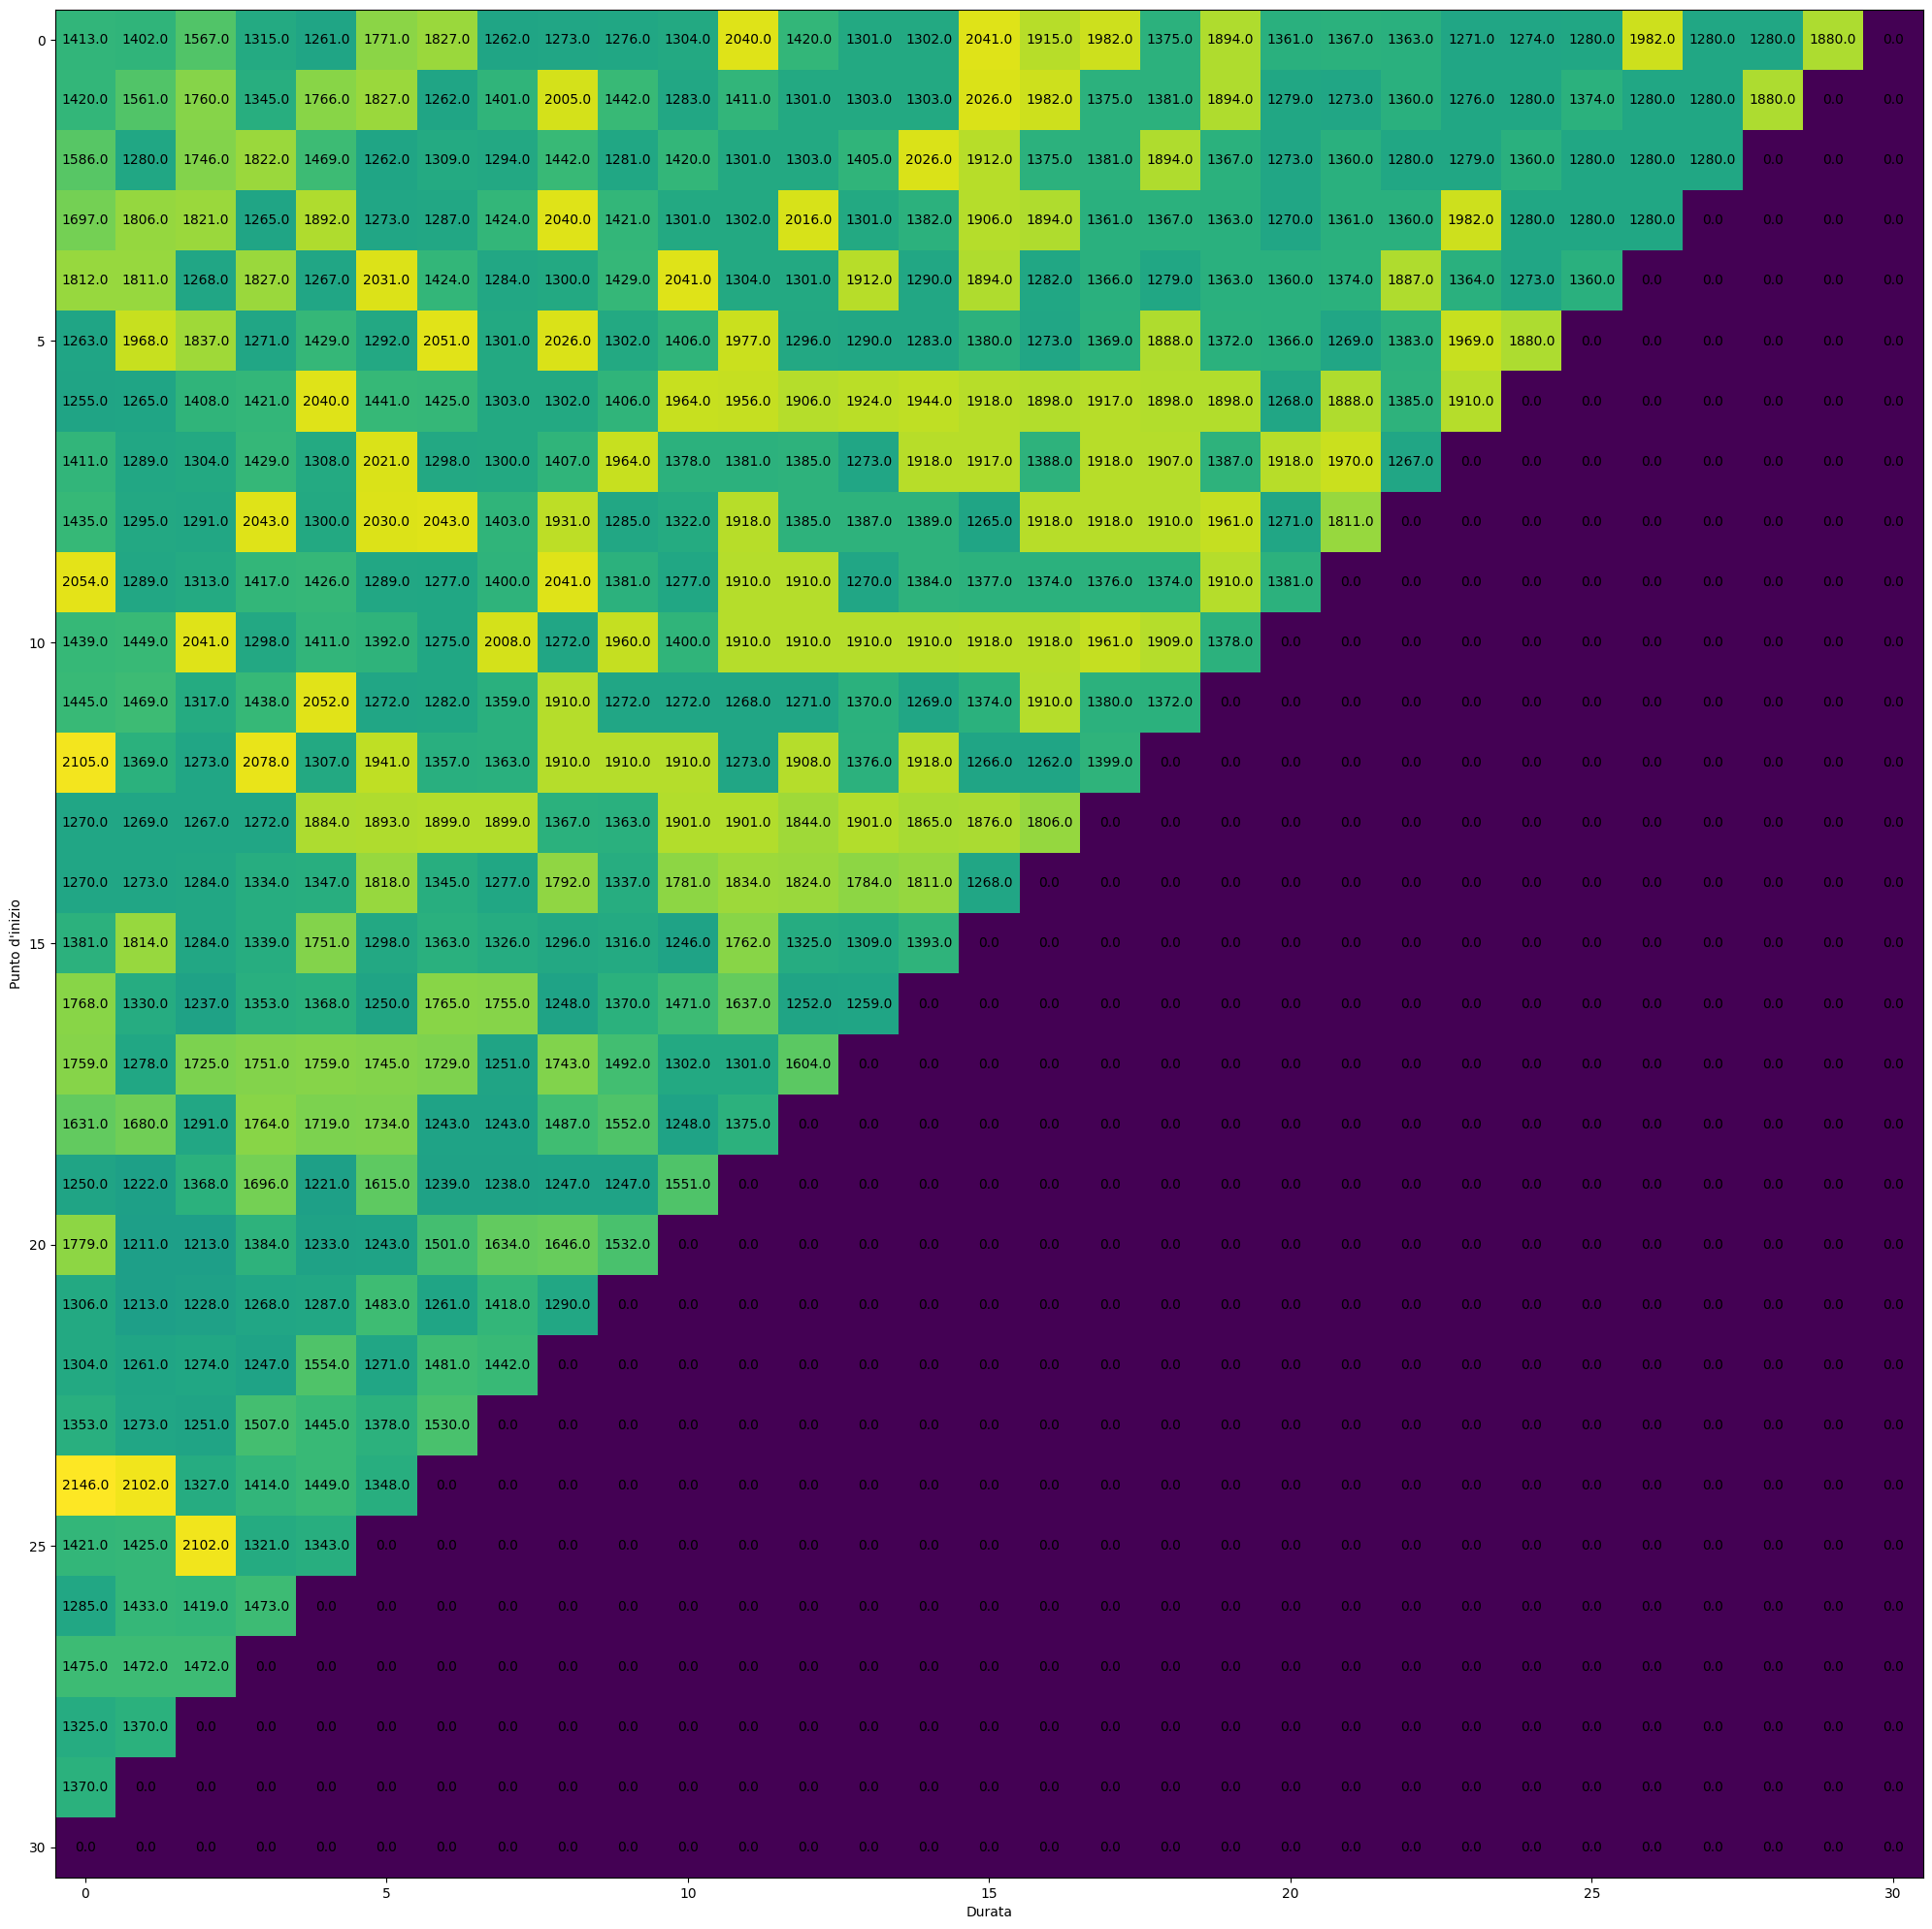

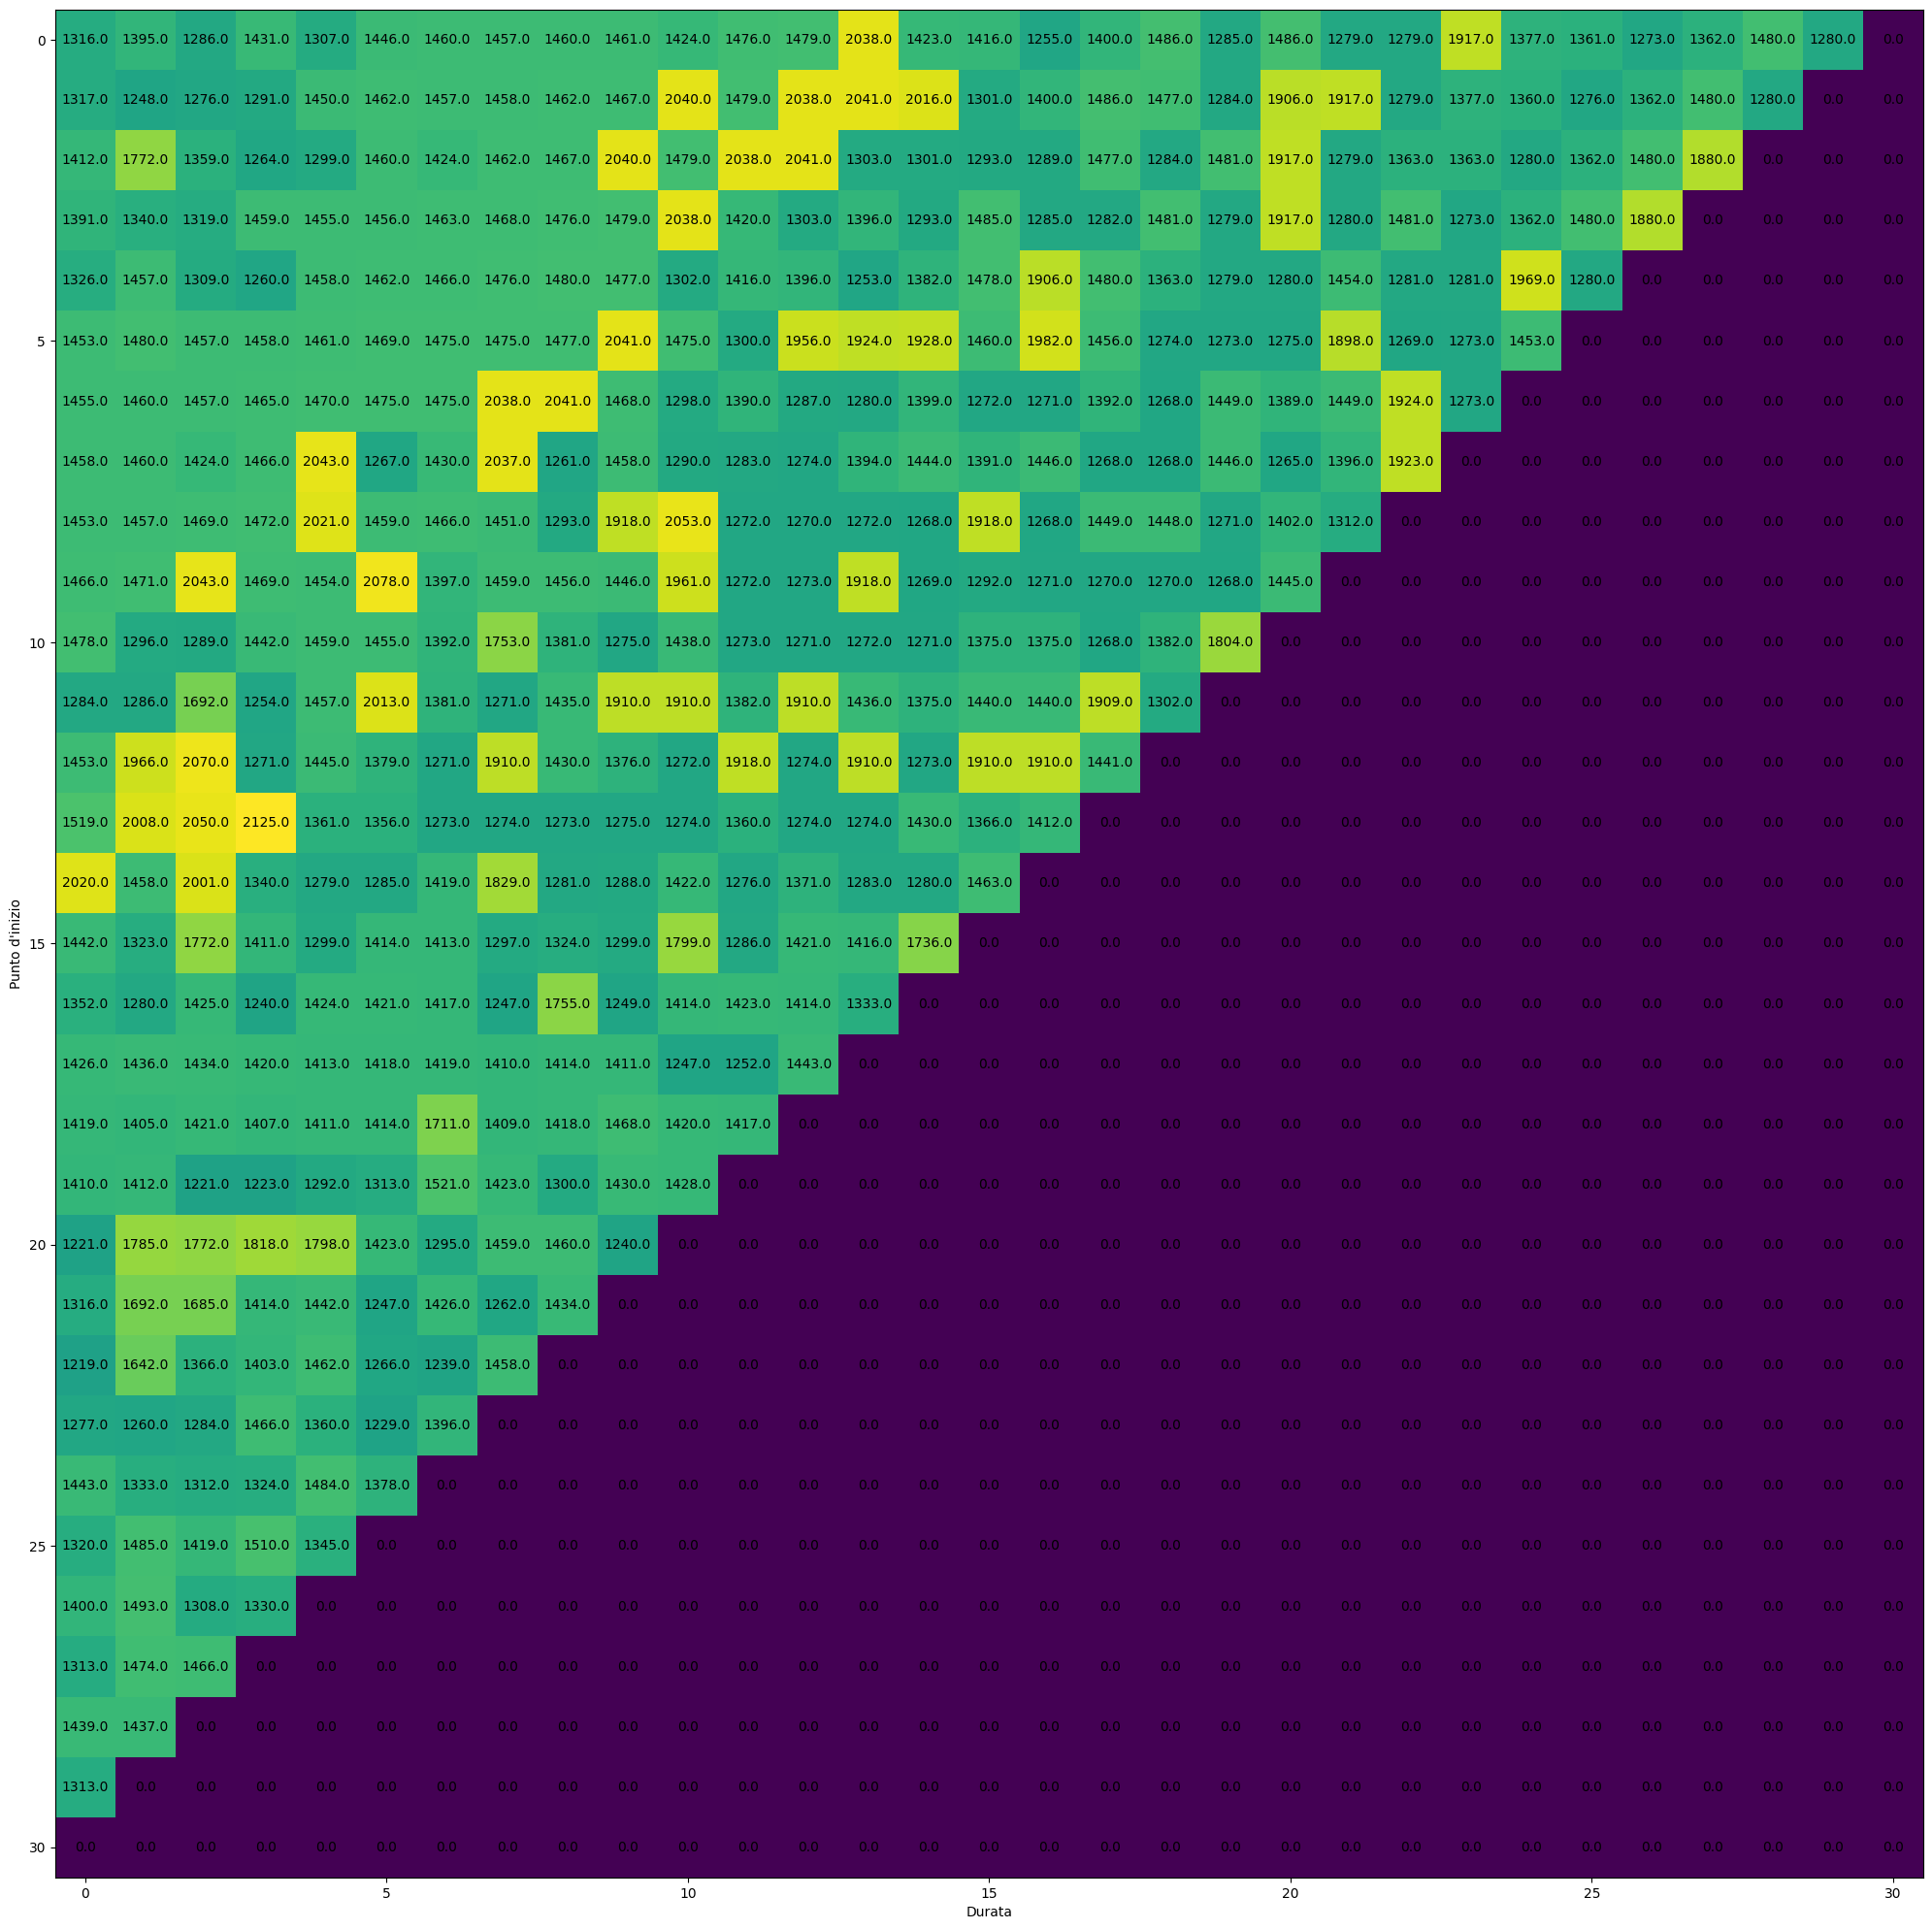

In [23]:

for p in range(num_cluster):
    fig, ax = plt.subplots()
    image = ax.imshow(sum_separation[:,:,p])

    plt.xlabel("Durata")
    plt.ylabel("Punto d'inizio")

    fig.set_size_inches(25,25)
    for i in range(x):
        for j in range(y):
            c = np.round(sum_separation[i,j,p],decimals=0)
            ax.text(j, i, str(c), va='center', ha='center')

# Calcolo della media per ogni cluster

In [24]:

cluster_mean = np.zeros([x,y,num_cluster])


for i in range(x):
    for j in range(y):
        if rese_total[i,j,0] is not None:
            for k in range(num_cluster):
                cluster_mean[i,j,k] = rese_total[i,j,k].mean()


In [25]:
from itertools import combinations
perm = list(combinations(range(num_cluster), 2))
print(list(perm))
print(perm[0][1])

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
1


# Calcolo della separazione usando la media della distanza dei centroidi

In [26]:
import math
from itertools import combinations
perm = list(combinations(range(num_cluster), 2))

separation = np.zeros([x,y,math.comb(num_cluster, 2)])

for i in range(x):
    for j in range(y):
        if rese_total[i,j,0] is not None:
            for cluster_couple,index in zip(perm,range(math.comb(num_cluster, 2))):        
                separation[i,j,index]= abs(cluster_mean[i,j,cluster_couple[0]]-cluster_mean[i,j,cluster_couple[1]])

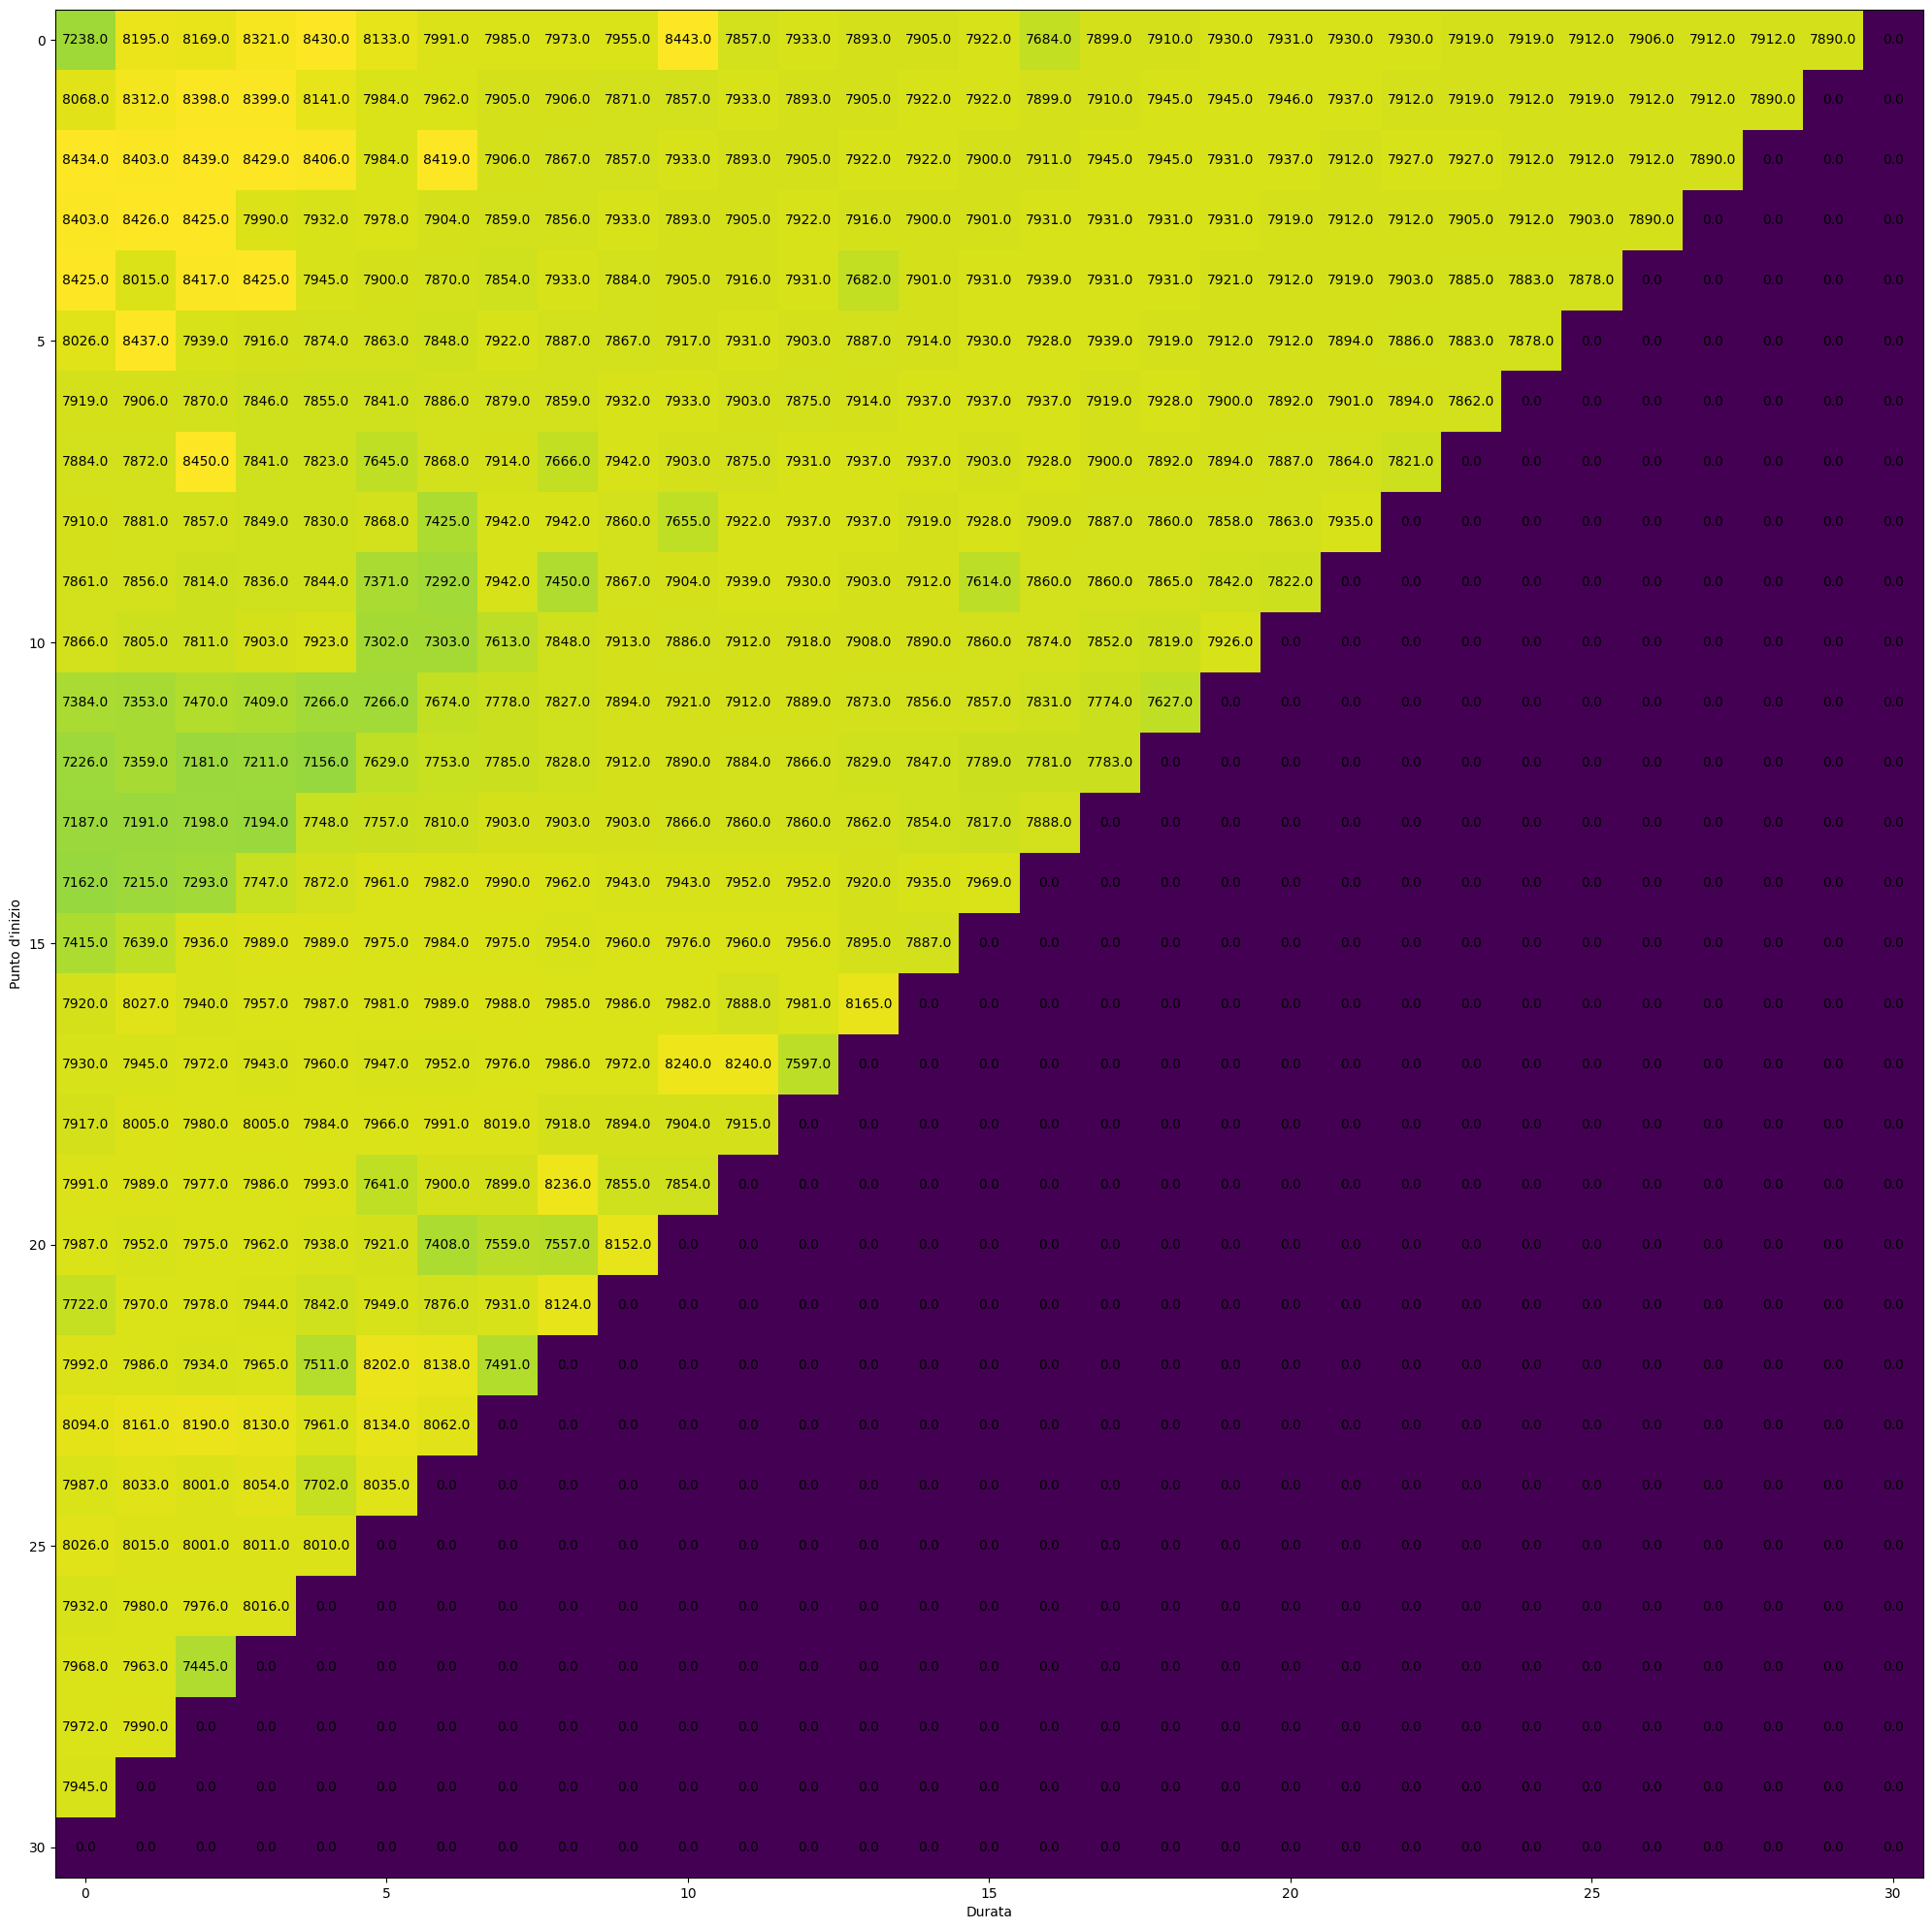

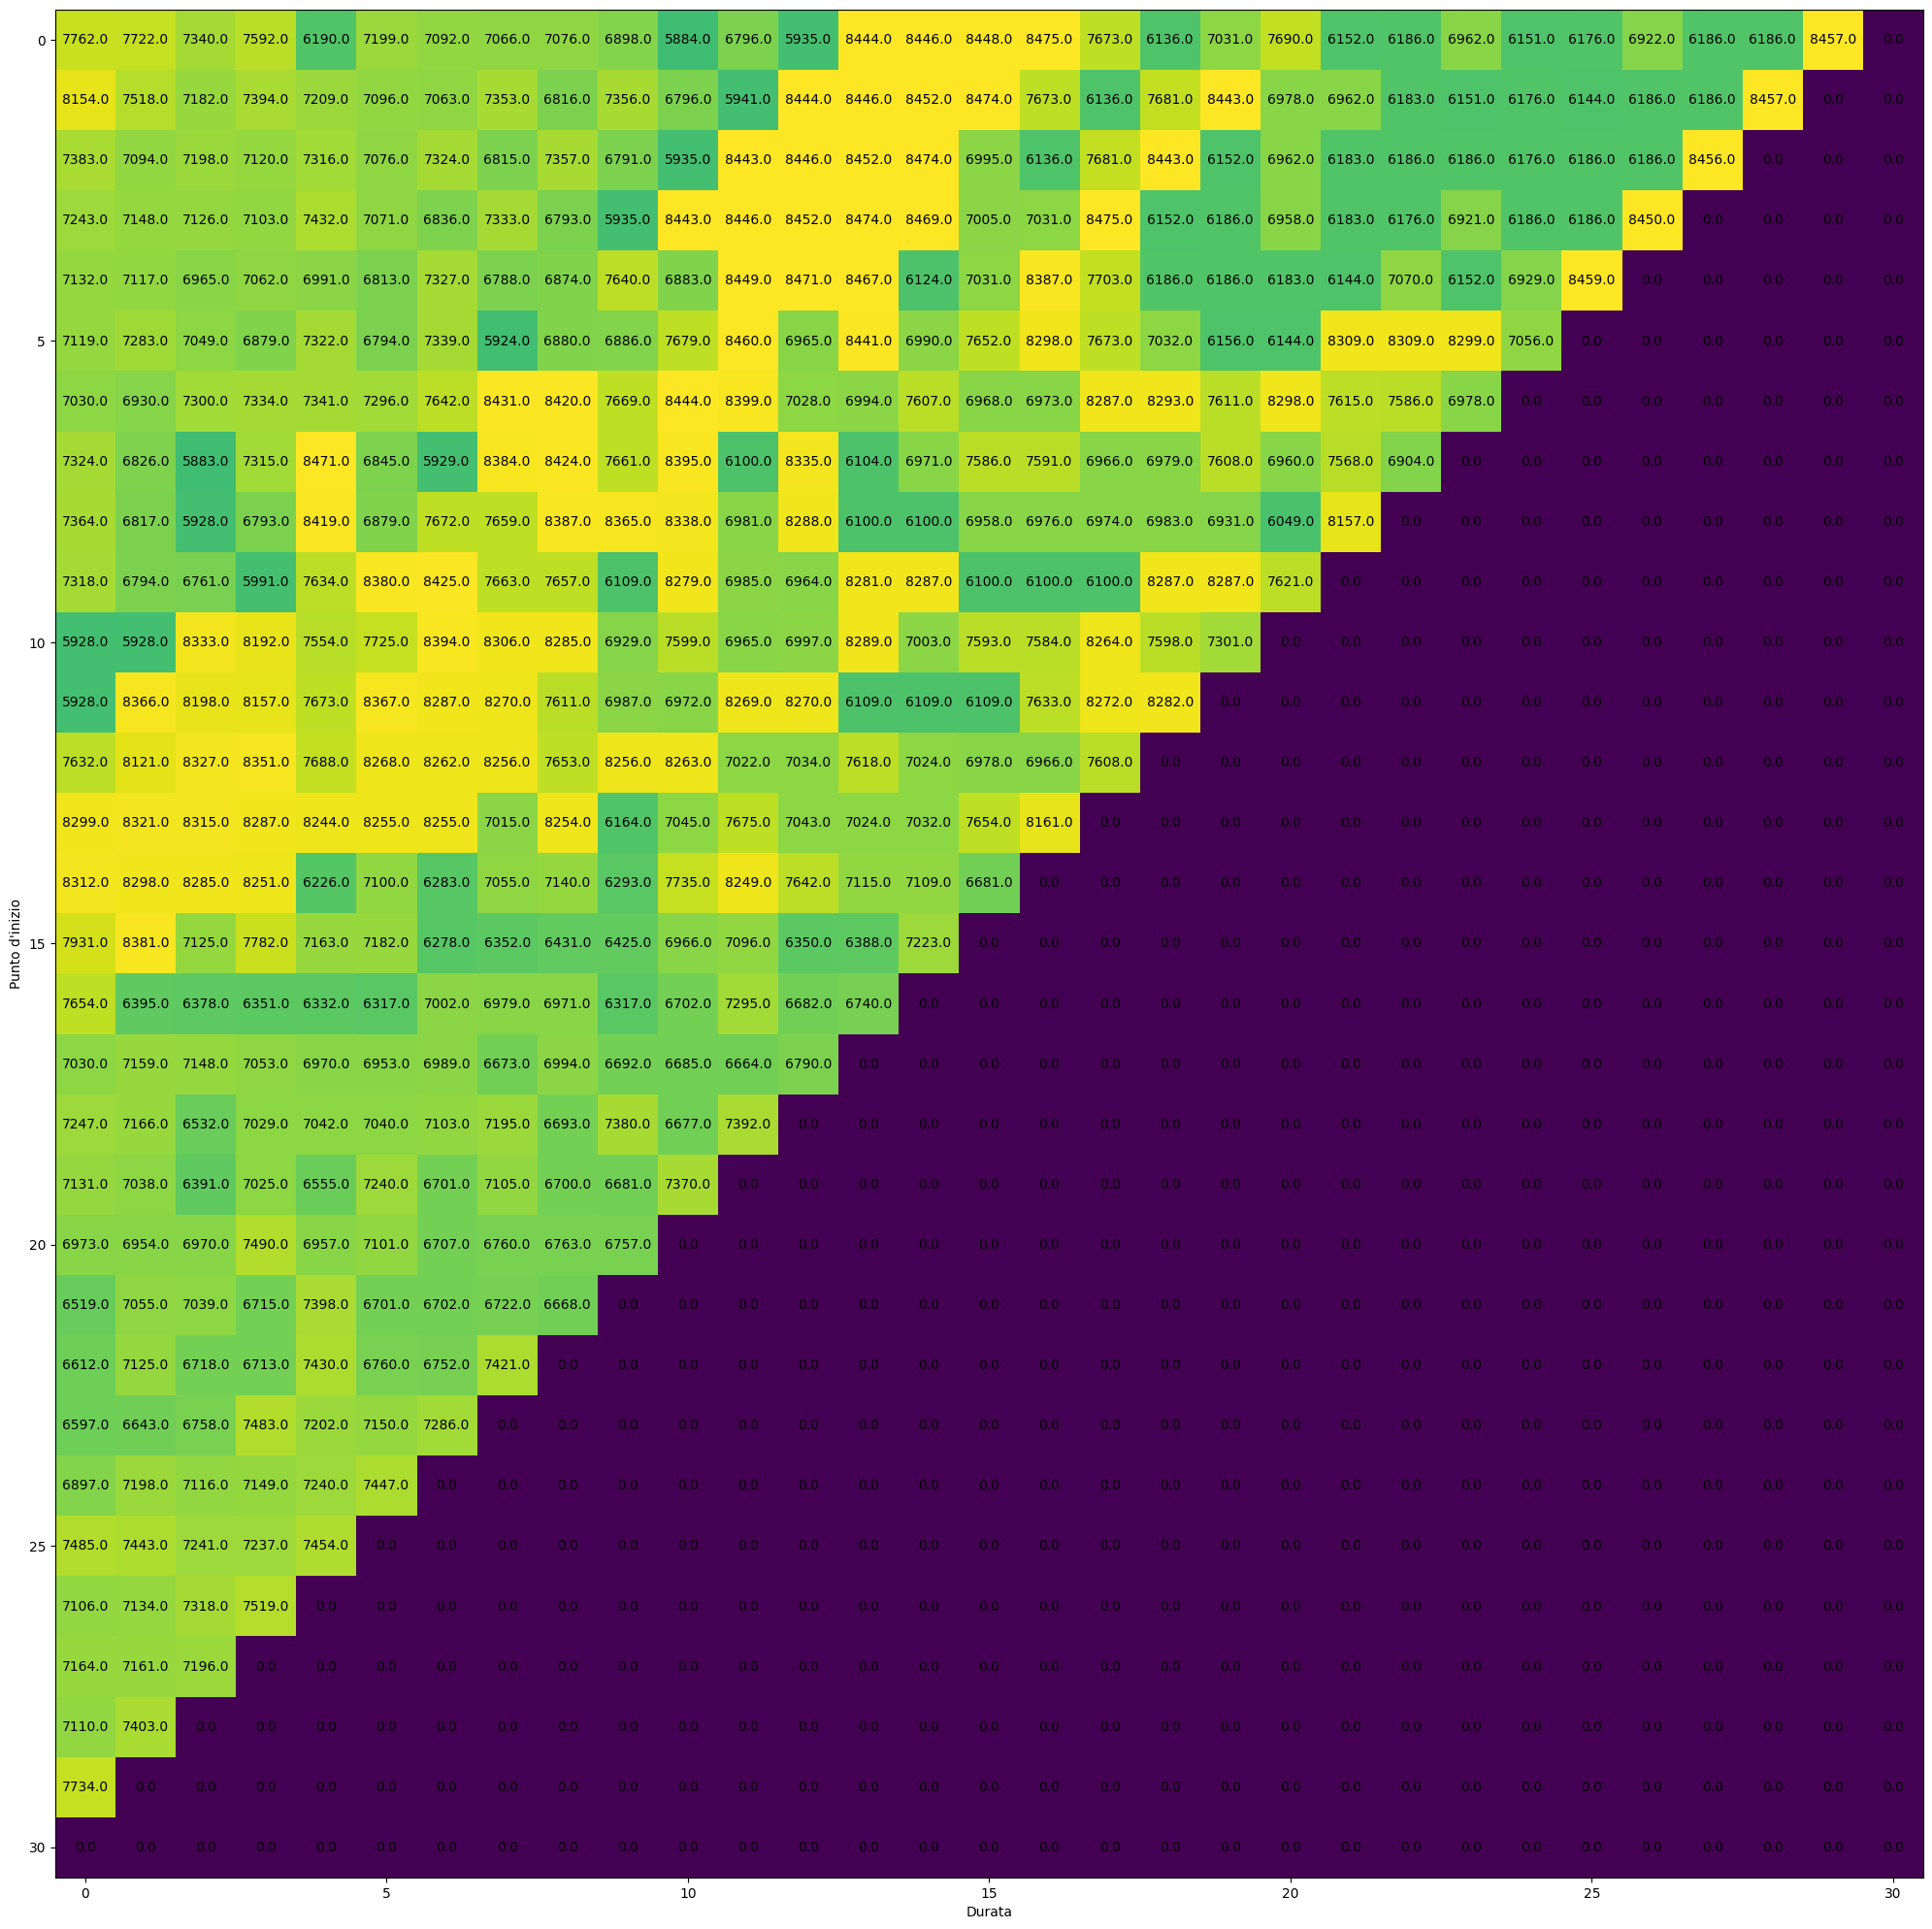

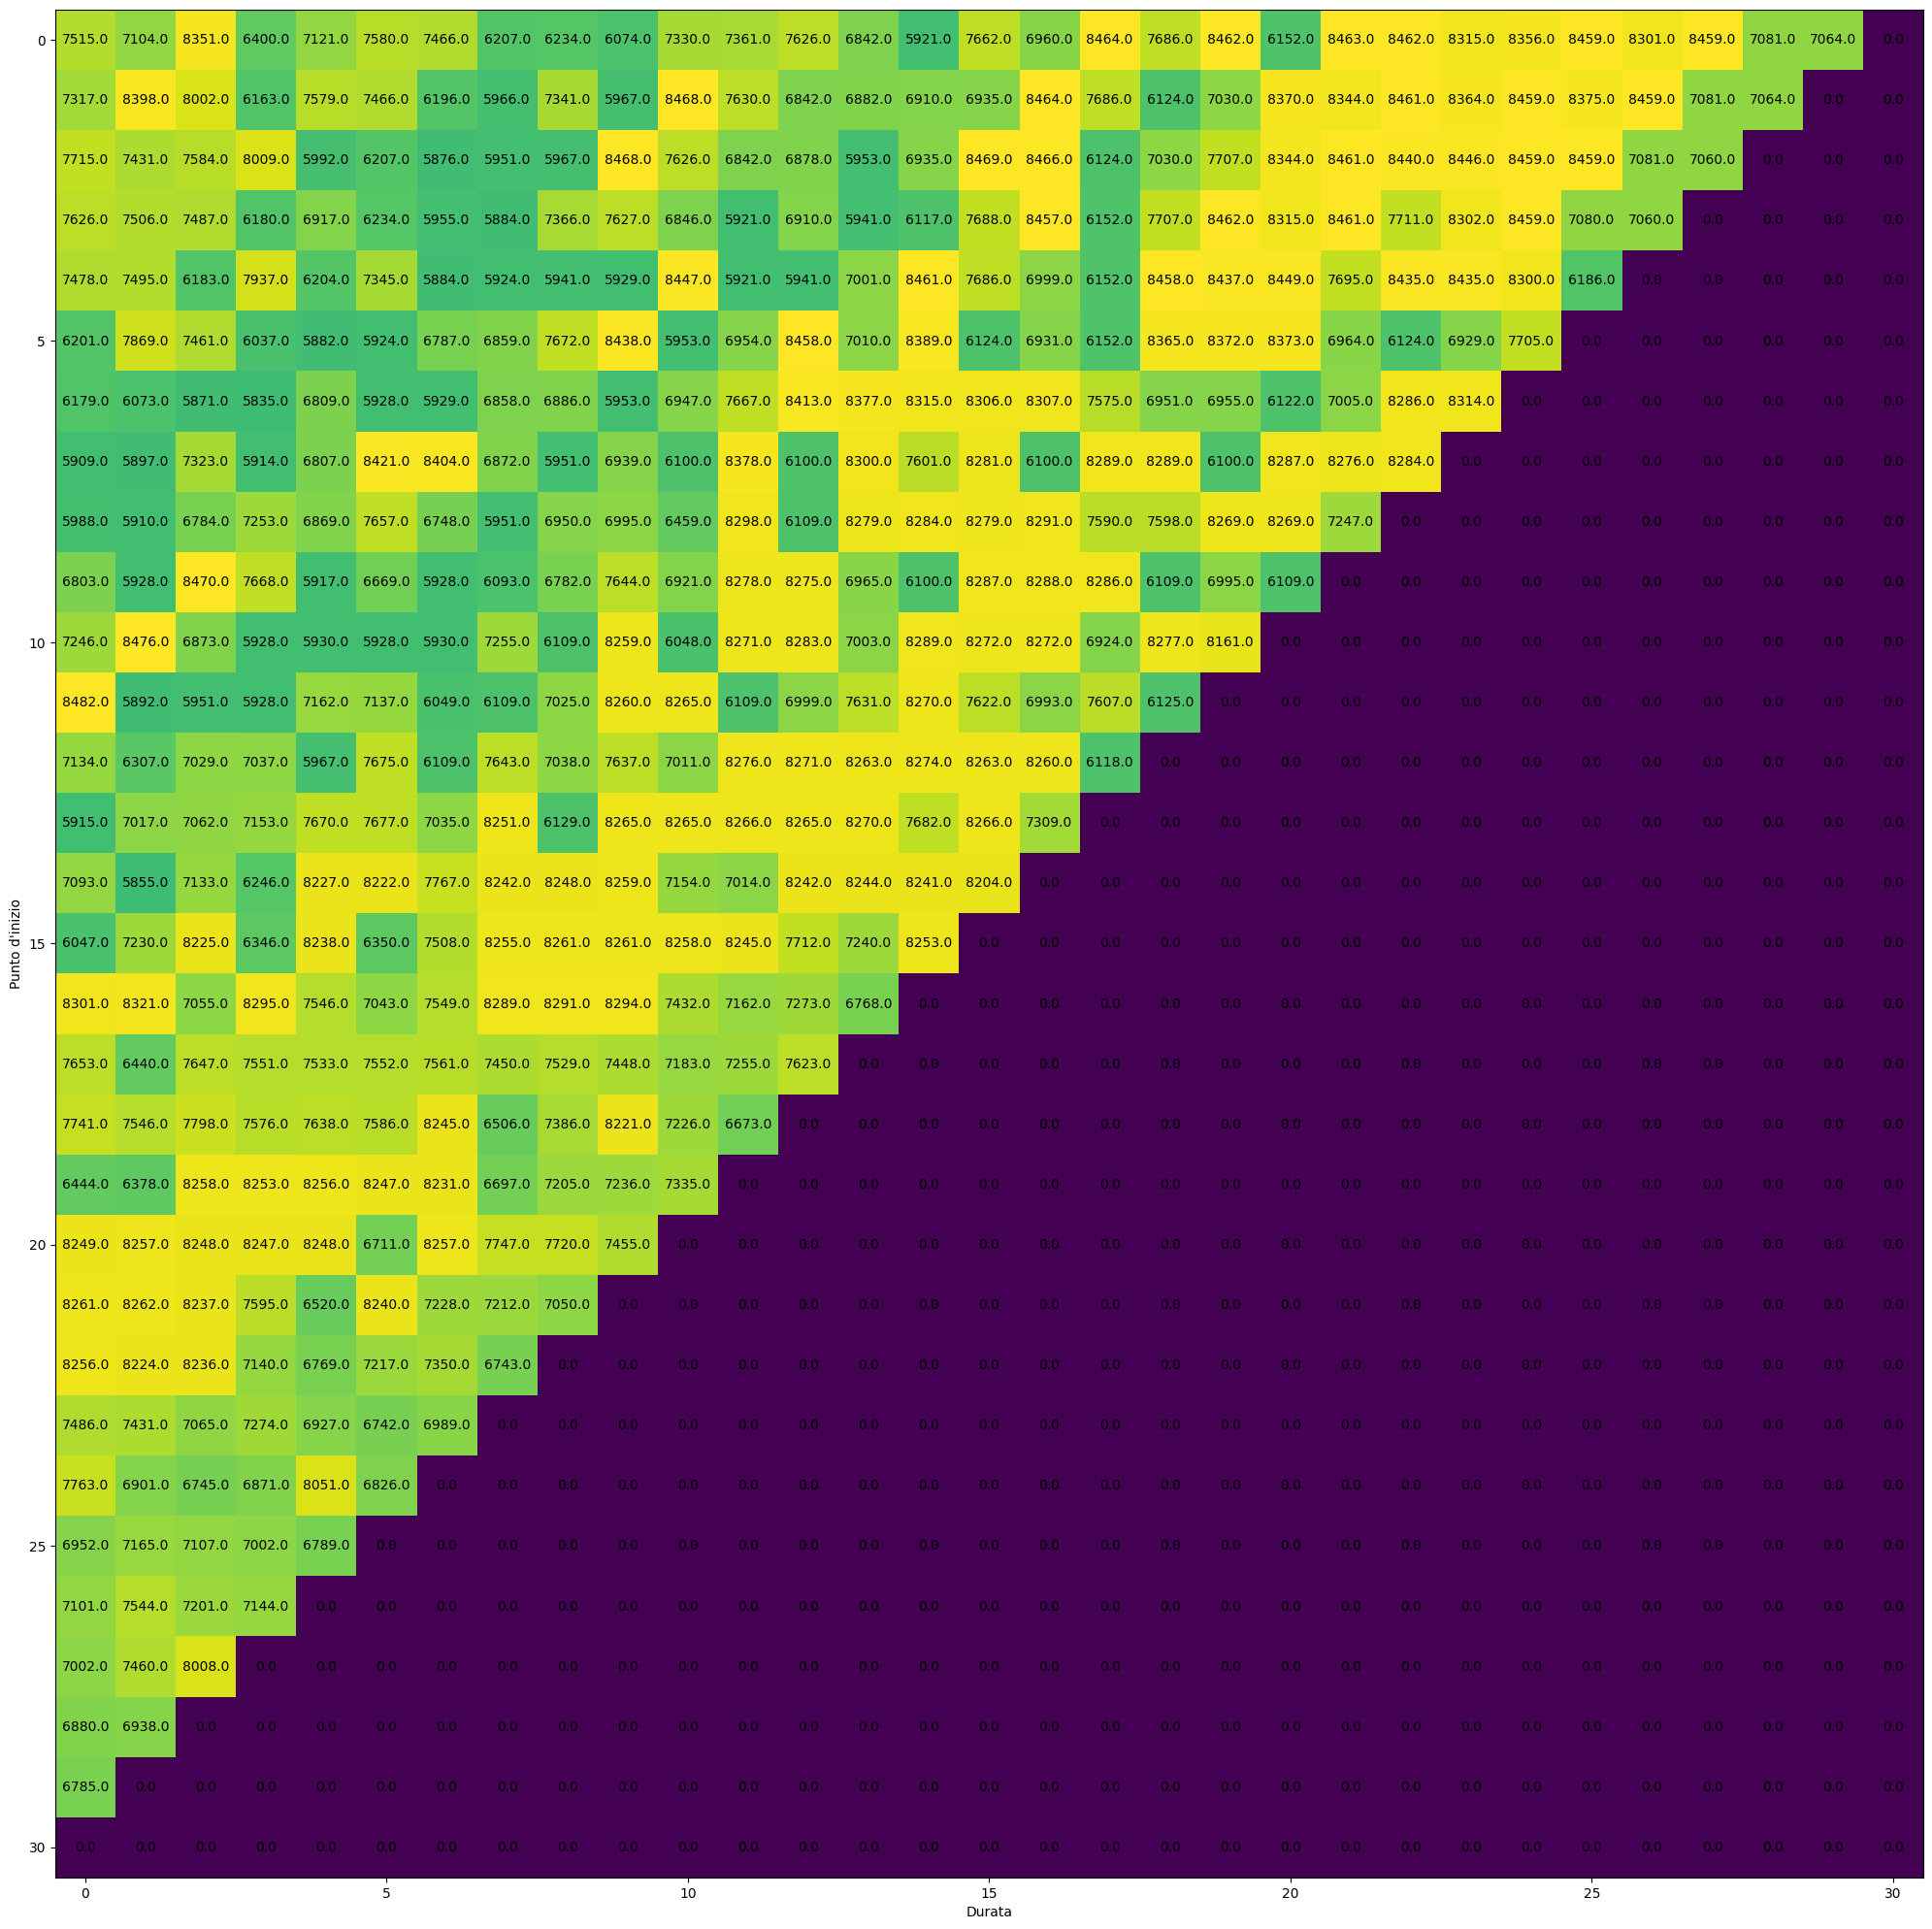

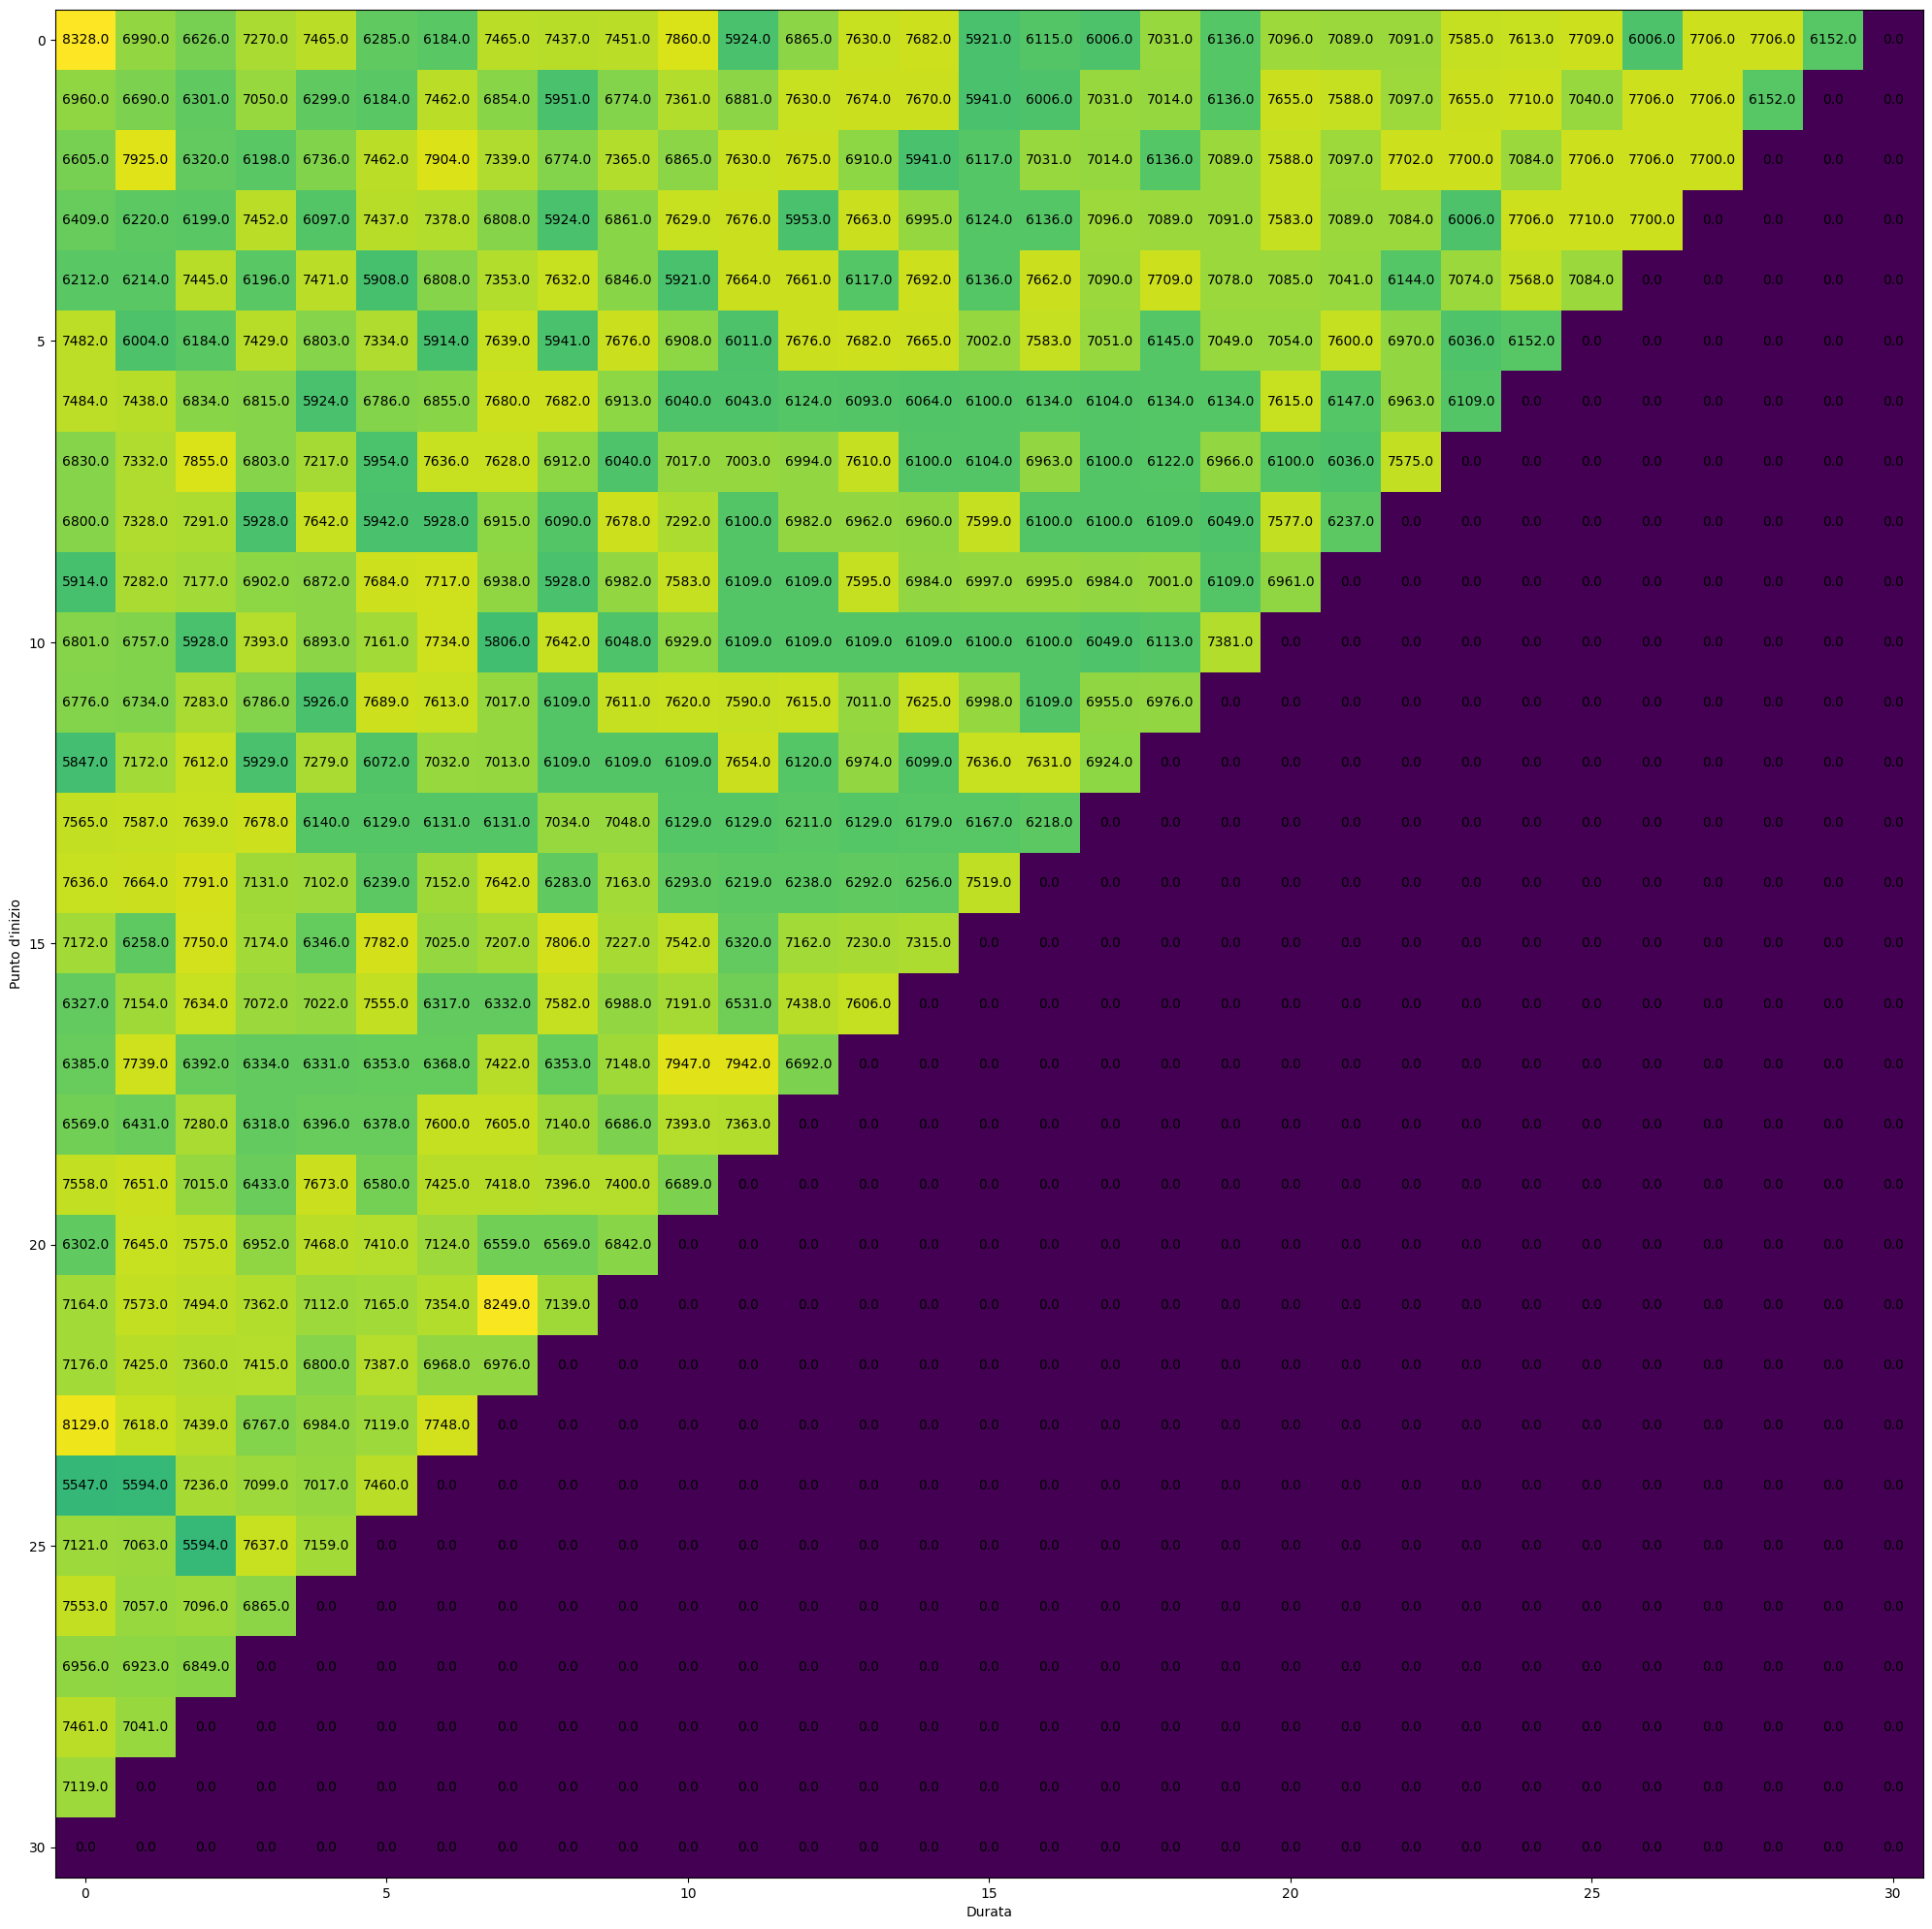

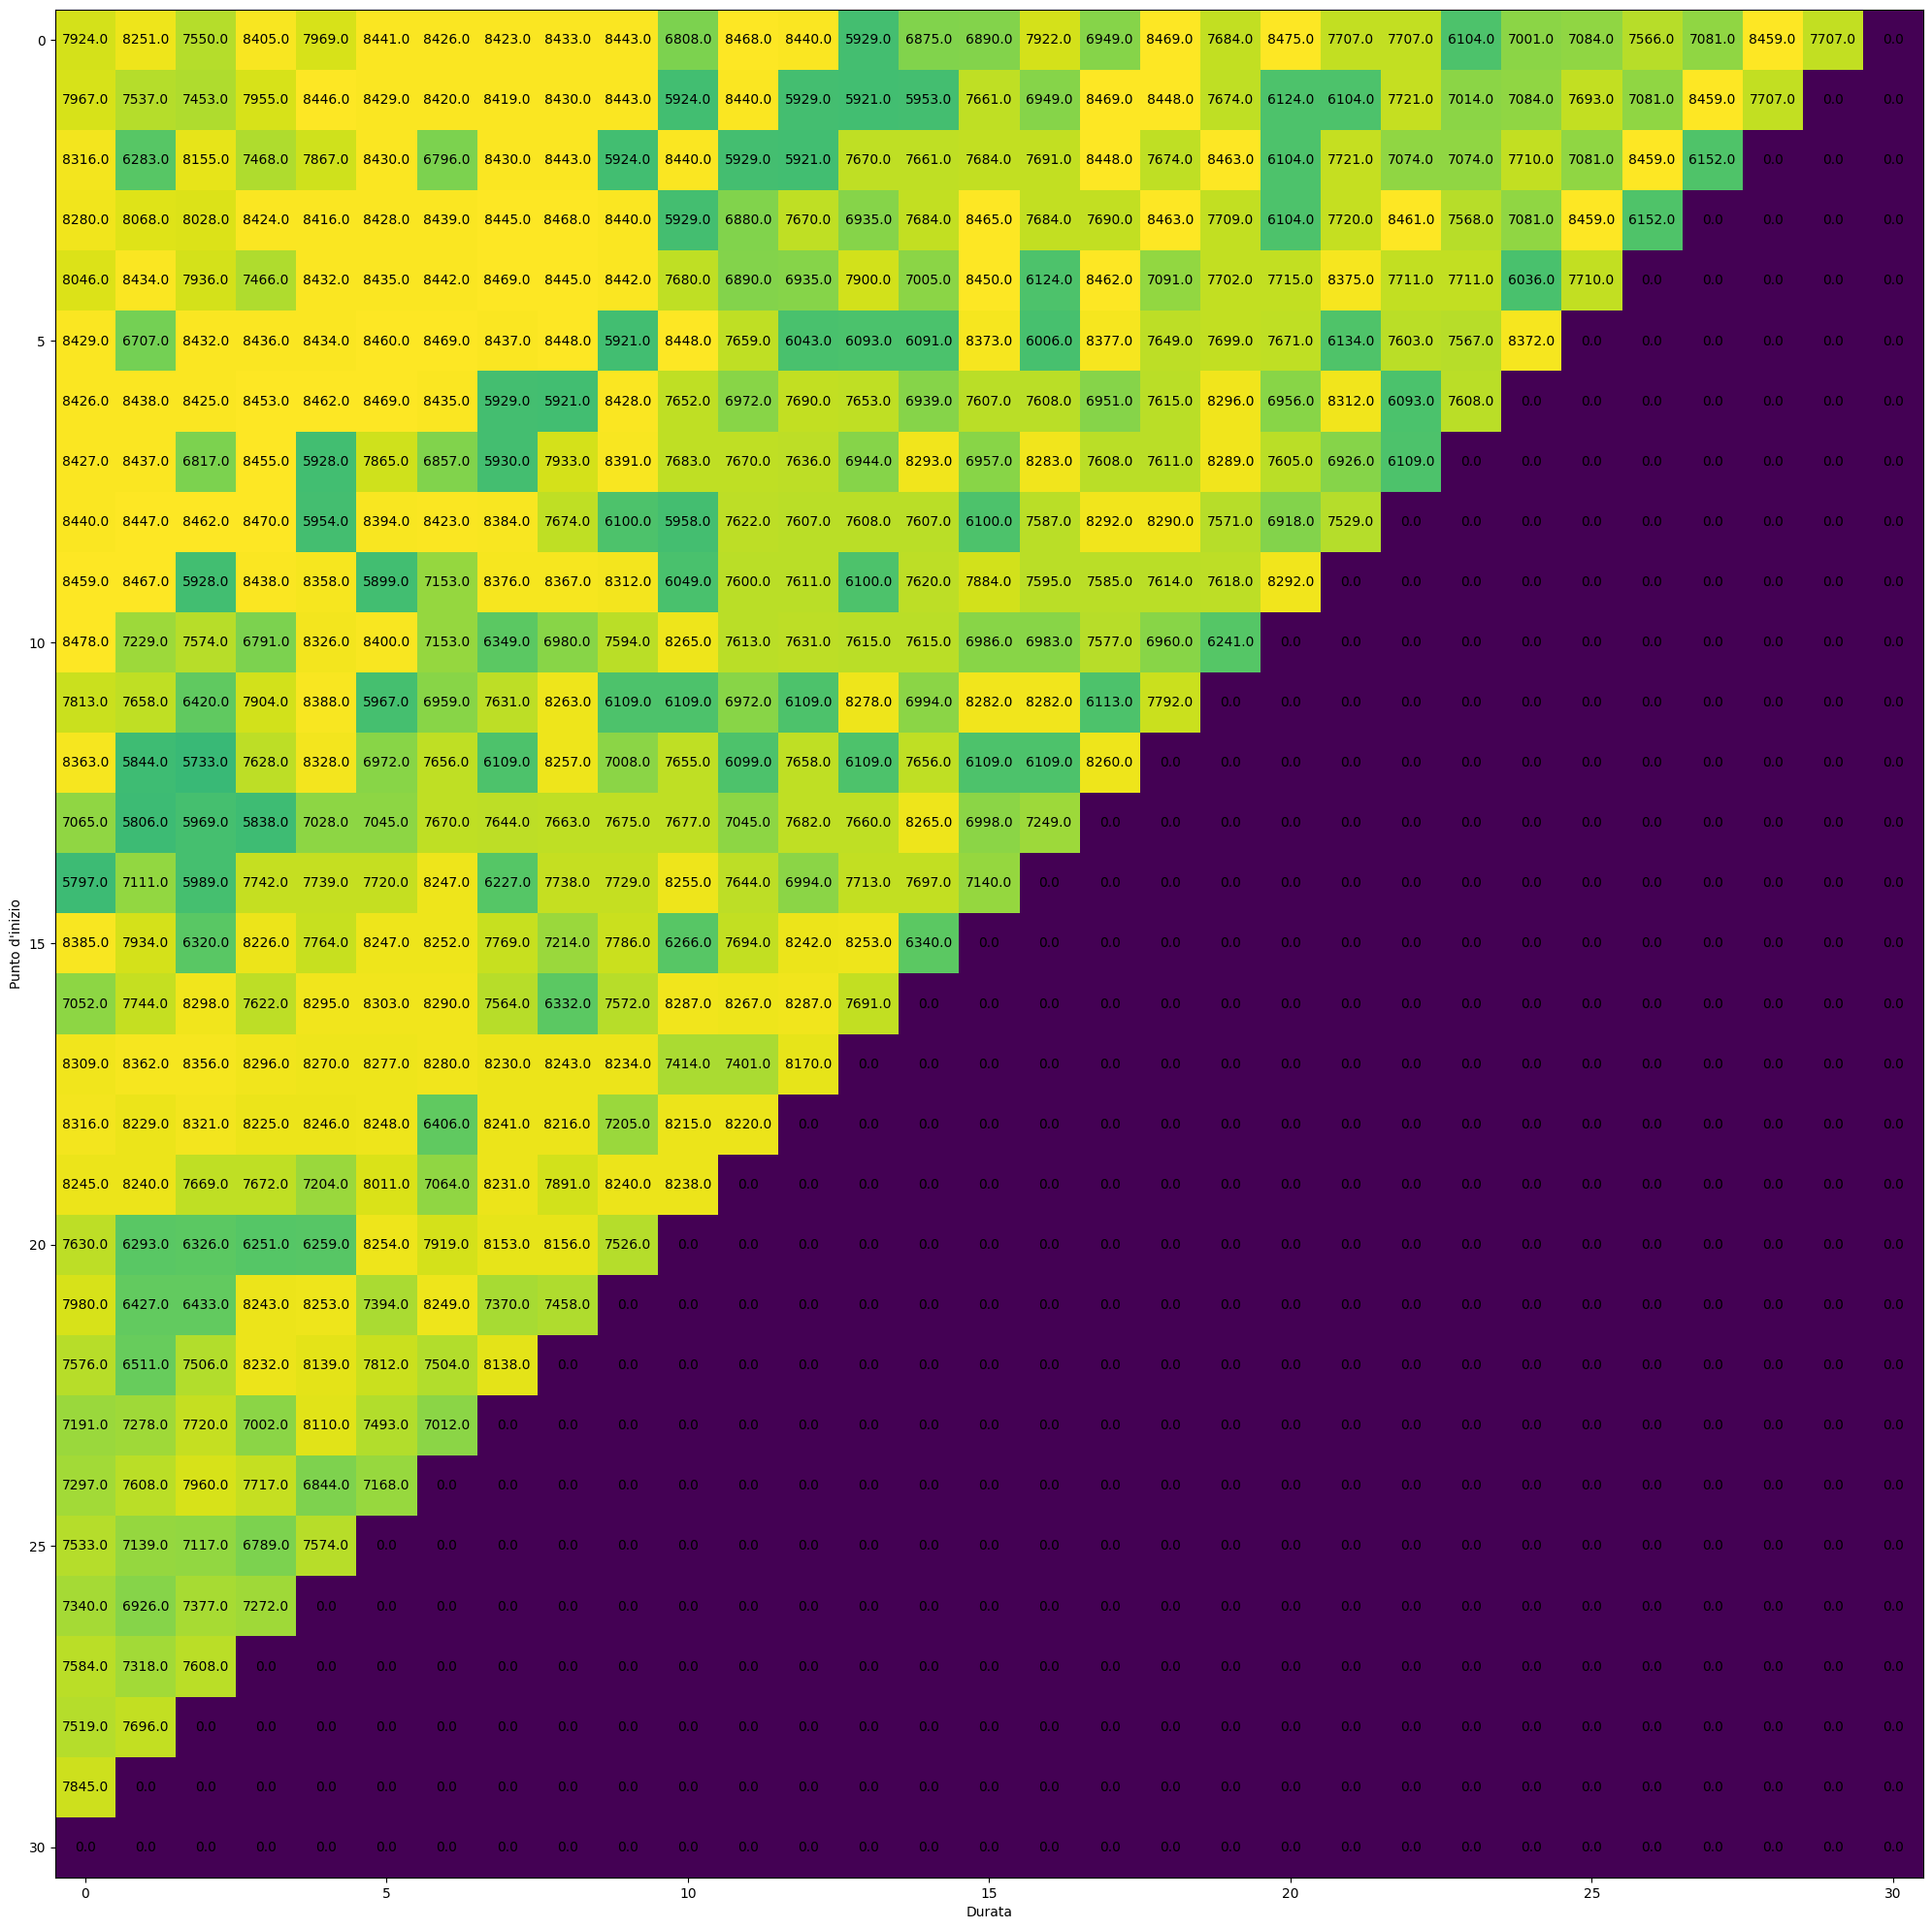

In [27]:
# Andiamo a stampare le medie per ogni cluster
for p in range(0,num_cluster):
    fig, ax = plt.subplots()

    image = ax.imshow(cluster_mean[:,:,p])


    plt.xlabel("Durata")
    plt.ylabel("Punto d'inizio")

    fig.set_size_inches(25,25)
    for i in range(0,cluster_mean.shape[0]):
        for j in range(0,cluster_mean.shape[1]):
            c = np.round(cluster_mean[i,j,p],decimals=0)
            ax.text(j, i, str(c), va='center', ha='center')

# Rappresentazione della deviazione standard e della media in uno scatter plot

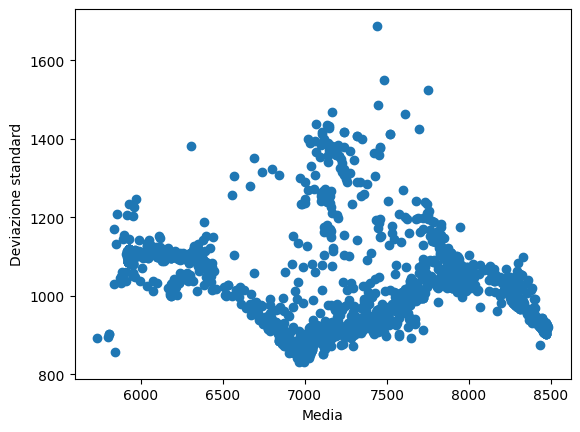

In [28]:
x = cluster_deviation[cluster_deviation > 100].flatten()

y = cluster_mean[cluster_deviation > 100].flatten()

plt.ylabel("Deviazione standard")
plt.xlabel("Media")

plt.scatter(y, x)
plt.show()